# Case Study 1

Studying the PDE:

${\partial u \over \partial t} = \nu {\partial^2 u \over \partial y^2}$

Considering a viuscous fluid between two parallel plates going to infinity, with viscocity $\nu$.

Initial conditions:
- $u(y=0, t=0) = U_0$
- $u(0<y\le h, t=0) = 0$

Boundary conditions: (Constant Dirichlet)
- $u(y=0, t) = U_0$
- $u(y=h, t) = 0$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import celluloid
%matplotlib notebook

### Problem parameters

In [2]:
h = 0.04 # m distance between plates (maximal y value)
v = 0.000217 # m^2/s viscosity
dy = 0.001 #m
jm = 40 # number of steps in y (jm + 1 points)
U0 = 40 #m/s initial velocity
T = 1.08 #s maximal t value

### Initial and Boundary Conditions

In [3]:
#y grid
y = np.linspace(0, h, jm + 1)

uIC = np.zeros(jm + 1)
uIC[0] = U0

In [4]:
uIC

array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

## 1. Analytical Solution
Written down as a series of complimentary error functions:


$u$ $= U_0\{\sum\limits_{n=0}^{\infty} \text{erfc}[2n\eta_1 + \eta] - \sum\limits_{n=0}^{\infty}\text{erfc}[2(n+1)\eta_1 - \eta]\}$

$= U_0 \{\text{erfc}(\eta) - \text{erfc}(2\eta_1 - \eta) + \text{erfc}(2\eta_1+\eta) - \text{erfc}(4\eta_1-\eta) + \text{erfc}(4\eta_1+\eta)\; - \; ...\}$

where

$\eta = \frac{y}{2\sqrt{\nu t}}$ and $\eta_1 = \frac{h}{2\sqrt{\nu t}}$.

Also,

$\text{erfc}(x) = 1 - \text{erf}(x)$

#### Note
This series must be truncated at a large enough $n$ - write code to check the difference between absolute value of terms such that they are low enough (to ensure convergence). The next term's contribution in the summand will always be smaller than the previous one, and so the sum converges (the greater the input of erfc, the smaller the output).

The error due to truncation depends on t.

The solution at t = 0 is undefined in the analytic solution (but it is given by initial conditions). As $\eta_1 > 0$, and $\eta_1 \ge \eta$, clearly the series converges as the next term in the summand always decreases.

### Calculating the solution (Truncating the series)

In [5]:
# Define erfc function
def erfc(x):
    return 1 - m.erf(x)

# Define analytic u(y, t) solution as a function of y and t explicitly
def u_yt(y, t):
    # define eta and eta1
    eta = y / (2*np.sqrt(v*t))
    eta1 = h / (2*np.sqrt(v*t))
    
    # Initialise u
    u = 0
    u_n = [0]
    
    # Iterate over sum, truncating at epsilon, initialise udiff as inf, n as 0
    epsilon = 1e-100
    udiff = float('inf')
    
    n=0
    while udiff > epsilon:
        # add nth part of sum
        u += erfc(2*n*eta1 + eta) - erfc(2*(n+1)*eta1 - eta)
        
        # store total up to nth part
        u_n.append(u)
        
        # calculate difference in sum (note indices are +1 since initialised 0 at index 0, then n=0 at index 1, etc...)
        udiff = u_n[n+1] - u_n[n]
        
        # increment n
        n += 1
    
    # multiply by U_0 and return
    return U0*u

# Define analytic solution u(j, n, dt, dy) as a function of grid point positions and step sizes (j = 0, ..., jm & n = 0, ..., nm)
# Note the j indices match the row index of y-grid spacing, and the n indices match the column index of t-grid spacing
def u_jn(j, n, dt, dy=dy):
    return u_yt(j*dy, n*dt)

### Calculating analytical solution at grid points (given by dy, jm, dt, nm)

In [6]:
def asol(dt, nm, dy, jm): #dy and jm given above
    # initialise empty solution matrix
    asol = np.zeros((jm+1,nm+1))
    
    # initial conditions
    asol[:,0] = np.linspace(0, jm*dy, jm+1)
    
    # calculate the analytical value at each point
    for j in range(jm+1):
        for n in range(1, nm+1):
            asol[j][n] = u_jn(j, n, dt=dt, dy=dy)
    
    return asol

## Plotting and Error calculation Functions

In [7]:
# Visualising results
# Define a plotting function
def cellplot(sol):
    # initialize
    fig = plt.figure()
    animation_camera = celluloid.Camera(fig)

    # plot columns (over time)
    for i in range(nm+1):
        plt.plot(y, sol[:,i])
        plt.title('u solution evolving over time')
        plt.xlabel('y')
        plt.ylabel('u(y, t)')
        animation_camera.snap()
        
    animation = animation_camera.animate()
    return animation

In [8]:
# Calculating matrix of uSOL errors (rows = y grid, columns = time grid)

def err_matrix(nsol, dt, nm, dy, jm): # dy and jm given above
    # // Calculate analytic solution at grid points
    # initialise empty solution matrix
    asol = np.zeros((jm+1,nm+1))
    
    # initial conditions
    asol[:,0] = np.linspace(0, jm*dy, jm+1)
    
    # calculate the analytical value at each point
    for j in range(jm+1):
        for n in range(1, nm+1):
            asol[j][n] = u_jn(j, n, dt=dt, dy=dy)
    
    # // error = analytic - numeric
    err = np.subtract(asol, nsol)
        
    return err

## 2. FTCS Explicit

The FTCS Explicit approximation of the PDE is:

$\frac{u_{j}^{n+1} - u_j^{n}}{\Delta t} = \nu [\frac{u_{j+1}^{n} - 2u_j^n + u_{j-1}^n}{(\Delta y)^2}]$

Rearranging,

$u_j^{n+1} = u_j^n + ({\nu \Delta t \over (\Delta y)^2})[u_{j+1}^{n} - 2u_j^n + u_{j-1}^n] = ({\nu \Delta t \over (\Delta y)^2})u_{j+1}^n + (1 - 2{\nu \Delta t \over (\Delta y)^2}) u_j^n + ({\nu \Delta t \over (\Delta y)^2})u_{j-1}^n$

$u_j^{n+1} = \alpha u_{j+1}^n + (1 - 2\alpha) u_j^n + \alpha u_{j-1}^n$

where $\alpha = \frac{v\Delta t}{(dy)^2}$

### Coding up the algorithm

In [9]:
def FTCS(dt, nm, dy, jm):
    # Define empty solution matrix
    uSOL = np.zeros((jm + 1, nm + 1)) # column = certain time, row = u value across y grid
    uSOL[:,0] = np.linspace(0, jm*dy, jm+1)
    uSOL[0,:] = U0 # boundary condition (0 boundary for uSOL[-1, :] = 0 is already in place)
    
    # Define alpha coefficient
    alpha = dt*v/dy**2
    
    # Propagate through time,
    for n in range(1, nm+1):
        uSOL[1:-1, n] = alpha*uSOL[2:,n-1] + (1 - 2*alpha)*uSOL[1:-1, n-1] + alpha*uSOL[0:-2,n-1] # j+1, j, and j-1th terms
    
    return uSOL

### Trial 1: dt = 0.002, nm = 540 (STABLE)

In [10]:
dt = 0.002
nm = 540

# Define empty solution matrix
FTCSuSOL1 = FTCS(dt=dt, nm=nm, dy=dy, jm=jm)

In [11]:
# Print results
FTCSuSOL1[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [38.52057001, 38.52190268, 38.52323126, 38.52455576],
       [37.0442107 , 37.04686661, 37.04951435, 37.05215397],
       [35.57397099, 35.57793133, 35.58187952, 35.58581561],
       [34.11285648, 34.11809326, 34.12331401, 34.12851882],
       [32.66380827, 32.67028458, 32.67674114, 32.68317805],
       [31.22968242, 31.23735278, 31.24499985, 31.25262373],
       [29.81323021, 29.82204097, 29.83082511, 29.83958275],
       [28.41707928, 28.42696912, 28.43682925, 28.4466598 ],
       [27.043716  , 27.05461647, 27.06548442, 27.07631996],
       [25.69546902, 25.70730518, 25.71910626, 25.7308724 ],
       [24.3744943 , 24.38718532, 24.39983902, 24.41245554],
       [23.08276157, 23.09622146, 23.1096421 , 23.12302364],
       [21.82204241, 21.83618074, 21.85027821, 21.86433495],
       [20.59390005, 20.60862266, 20.62330313, 20.6379416 ],
       [19.39968075, 19.41489055, 19.43005725, 19.445181  ],
       [18.24050707, 18.

In [12]:
# Calculating error matrix
FTCS1err = err_matrix(FTCSuSOL1, dt=dt, nm=nm, dy=dy, jm=jm)
FTCS1err[:,-4:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00140815, -0.00140463, -0.00140113, -0.00139763],
       [-0.00280527, -0.00279827, -0.0027913 , -0.00278436],
       [-0.00418044, -0.00417006, -0.00415971, -0.0041494 ],
       [-0.00552302, -0.00550937, -0.00549577, -0.00548222],
       [-0.00682272, -0.00680596, -0.00678927, -0.00677264],
       [-0.00806973, -0.00805007, -0.00803049, -0.00801098],
       [-0.00925484, -0.00923252, -0.00921027, -0.0091881 ],
       [-0.01036953, -0.01034479, -0.01032014, -0.01029557],
       [-0.01140604, -0.01137916, -0.01135238, -0.01132569],
       [-0.01235743, -0.01232872, -0.01230011, -0.01227159],
       [-0.01321767, -0.01318744, -0.01315731, -0.01312727],
       [-0.01398166, -0.01395023, -0.0139189 , -0.01388766],
       [-0.01464526, -0.01461295, -0.01458073, -0.0145486 ],
       [-0.01520529, -0.01517241, -0.01513962, -0.01510693],
       [-0.01565954, -0.01562641, -0.01559336, -0.0155604 ],
       [-0.01600676, -0.

t=0.18 abs DE = 1.059859217108323
t=1.08 abs DE = 0.4134064162858566


<IPython.core.display.Javascript object>


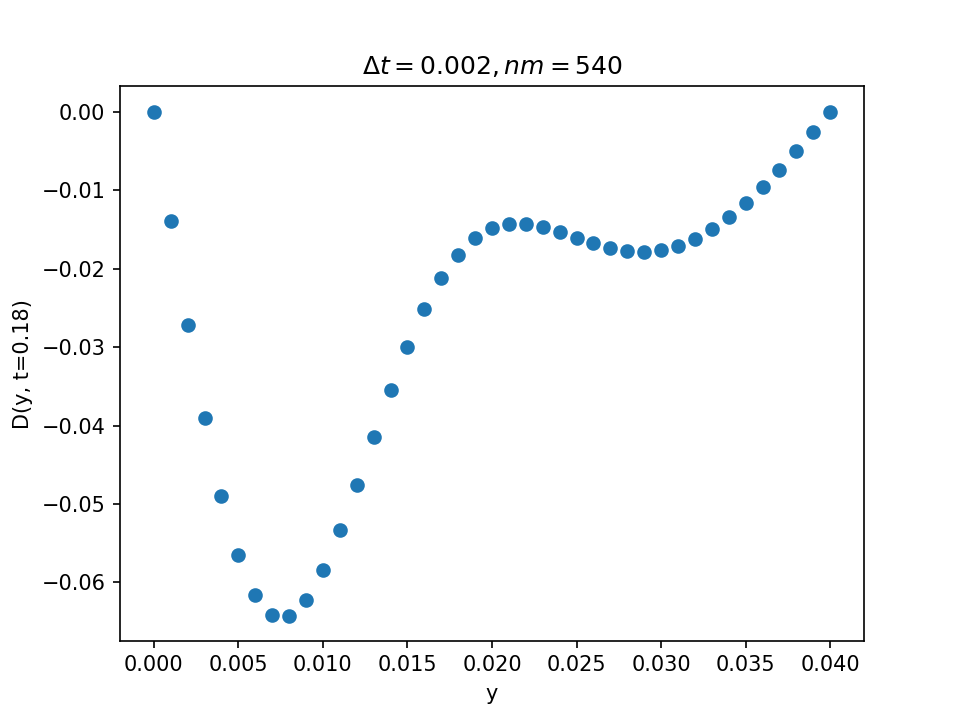

<IPython.core.display.Javascript object>


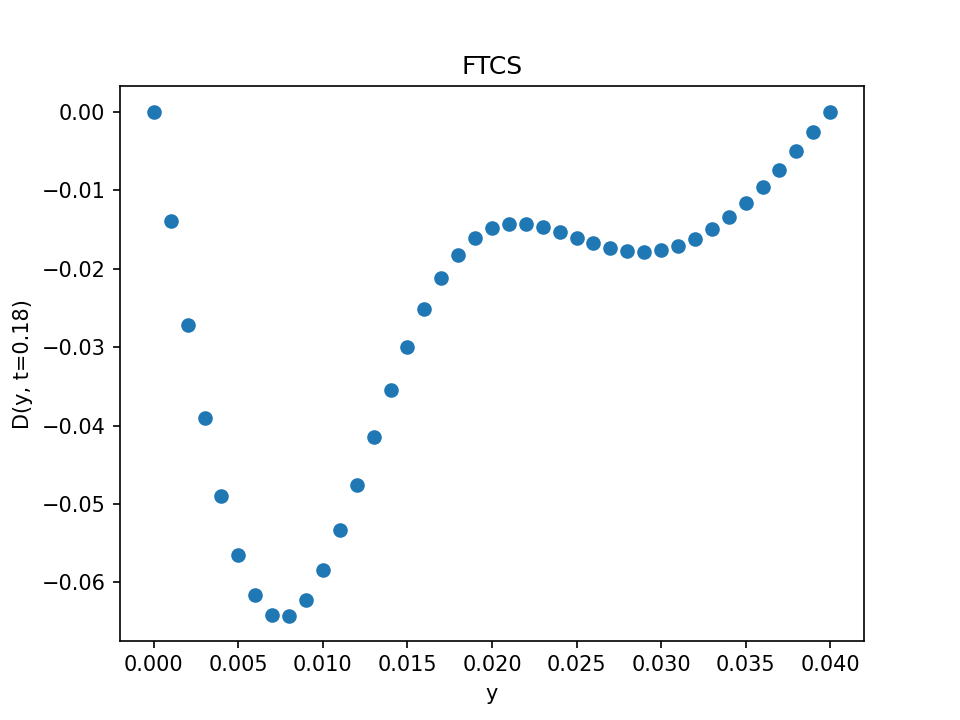

<IPython.core.display.Javascript object>


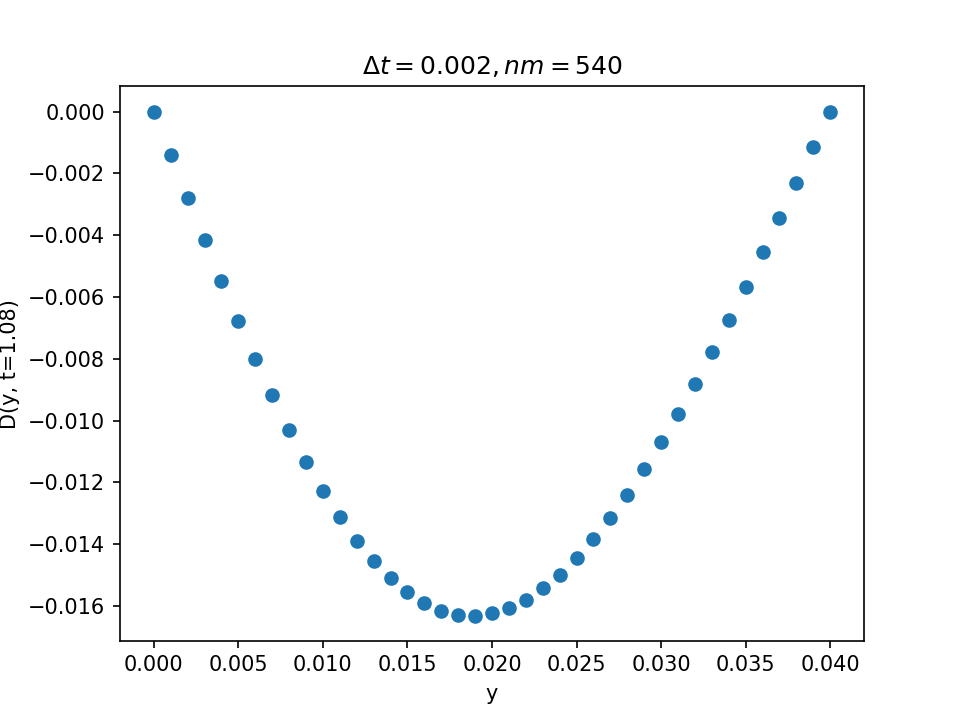

<IPython.core.display.Javascript object>


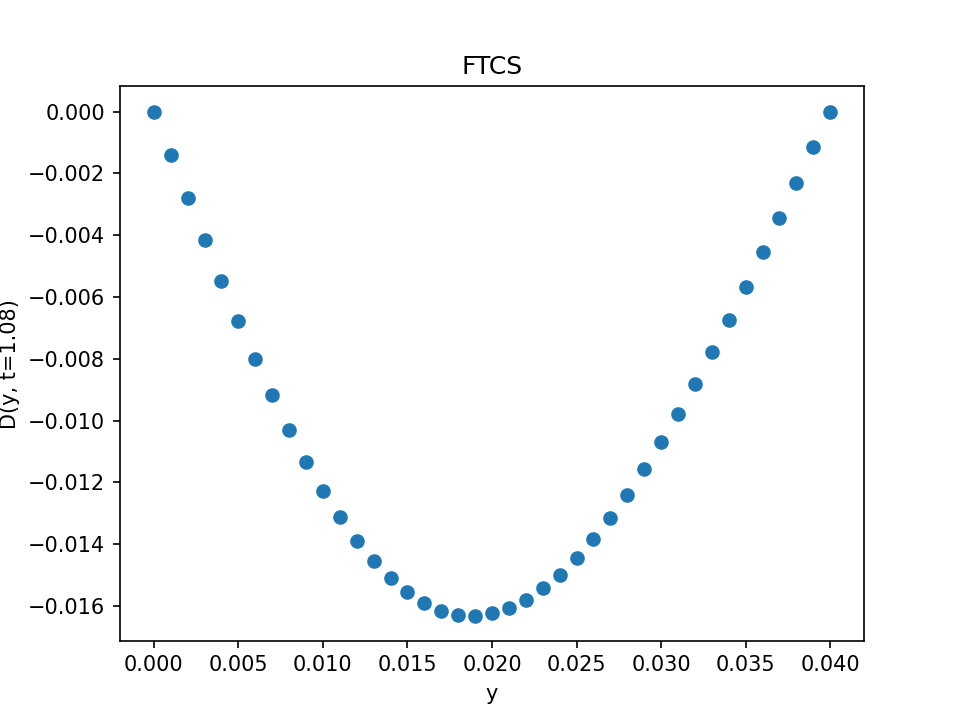

In [13]:
# Error plots: t=0.18, t=1.08 - compare to other methods and trial 2, 3
# time indices
t0ind = int(0.18/dt)
t1ind = -1

# error data
t0err = FTCS1err[:,t0ind]
t1err = FTCS1err[:,t1ind]


# ABSOLUTE DISCRETIZATION ERROR CALCULATION
abs_t0FTCS1err = np.sum(np.abs(t0err))
print(f't=0.18 abs DE = {abs_t0FTCS1err}')
abs_t1FTCS1err = np.sum(np.abs(t1err))
print(f't=1.08 abs DE = {abs_t1FTCS1err}')
# END OF ADEC


y = np.linspace(0, jm*dy, jm+1)

# plots
plt.figure()
plt.scatter(y, t0err)
plt.title('$\Delta t = 0.002, nm = 540$')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('FTCS T1 t=0.18.png')

plt.figure()
plt.scatter(y, t0err)
plt.title('FTCS')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('FTCS t=0.18.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.002, nm = 540$')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('FTCS T1 t=1.08.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('FTCS')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('FTCS t=1.08.png')

### Trial 2: dt = 0.0024, nm = 450 (UNSTABLE)

In [14]:
dt = 0.0024 # s
nm = 450 # s, steps in time (nm + 1 time points)

In [15]:
# Get solution
FTCSuSOL2 = FTCS(dt=dt, nm=nm, dy=dy, jm=jm)

In [16]:
# Print results
FTCSuSOL2[:,-4:] # unstable results: is alpha > 1/2? (need <= 2 for stability)

array([[ 4.00000000e+01,  4.00000000e+01,  4.00000000e+01,
         4.00000000e+01],
       [ 2.87458908e+12, -3.10262511e+12,  3.34876806e+12,
        -3.61445690e+12],
       [-5.72780761e+12,  6.18221746e+12, -6.67271150e+12,
         7.20215753e+12],
       [ 8.53850744e+12, -9.21598329e+12,  9.94726253e+12,
        -1.07366216e+13],
       [-1.12859815e+13,  1.21816029e+13, -1.31483629e+13,
         1.41919165e+13],
       [ 1.39501754e+13, -1.50574579e+13,  1.62527080e+13,
        -1.75429197e+13],
       [-1.65118883e+13,  1.78228475e+13, -1.92379795e+13,
         2.07655685e+13],
       [ 1.89529600e+13, -2.04581892e+13,  2.20830612e+13,
        -2.38370926e+13],
       [-2.12564413e+13,  2.29452026e+13, -2.47682365e+13,
         2.67362261e+13],
       [ 2.34067456e+13, -2.52670720e+13,  2.72753634e+13,
        -2.94433963e+13],
       [-2.53897786e+13,  2.74085861e+13, -2.95880254e+13,
         3.19408855e+13],
       [ 2.71930456e+13, -2.93562541e+13,  3.16916559e+13,
      

In [17]:
# Calculating error matrix: EXPLODES --> Check stability ratio
FTCS2err = err_matrix(FTCSuSOL2, dt=dt, nm=nm, dy=dy, jm=jm)
FTCS2err[:,-4:]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.87458908e+12,  3.10262511e+12, -3.34876806e+12,
         3.61445690e+12],
       [ 5.72780761e+12, -6.18221746e+12,  6.67271150e+12,
        -7.20215753e+12],
       [-8.53850744e+12,  9.21598329e+12, -9.94726253e+12,
         1.07366216e+13],
       [ 1.12859815e+13, -1.21816029e+13,  1.31483629e+13,
        -1.41919165e+13],
       [-1.39501754e+13,  1.50574579e+13, -1.62527080e+13,
         1.75429197e+13],
       [ 1.65118883e+13, -1.78228475e+13,  1.92379795e+13,
        -2.07655685e+13],
       [-1.89529600e+13,  2.04581892e+13, -2.20830612e+13,
         2.38370926e+13],
       [ 2.12564413e+13, -2.29452026e+13,  2.47682365e+13,
        -2.67362261e+13],
       [-2.34067456e+13,  2.52670720e+13, -2.72753634e+13,
         2.94433963e+13],
       [ 2.53897786e+13, -2.74085861e+13,  2.95880254e+13,
        -3.19408855e+13],
       [-2.71930456e+13,  2.93562541e+13, -3.16916559e+13,
      

t=0.18 abs DE = 375.8753428056341
t=1.08 abs DE = 1094277740269959.8


<IPython.core.display.Javascript object>


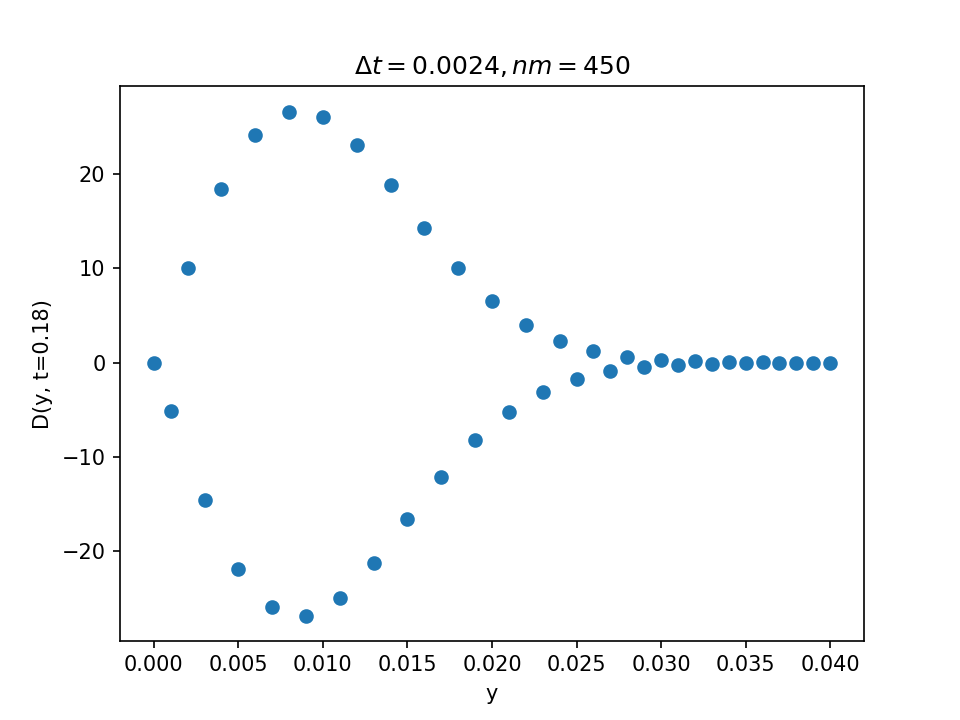

<IPython.core.display.Javascript object>


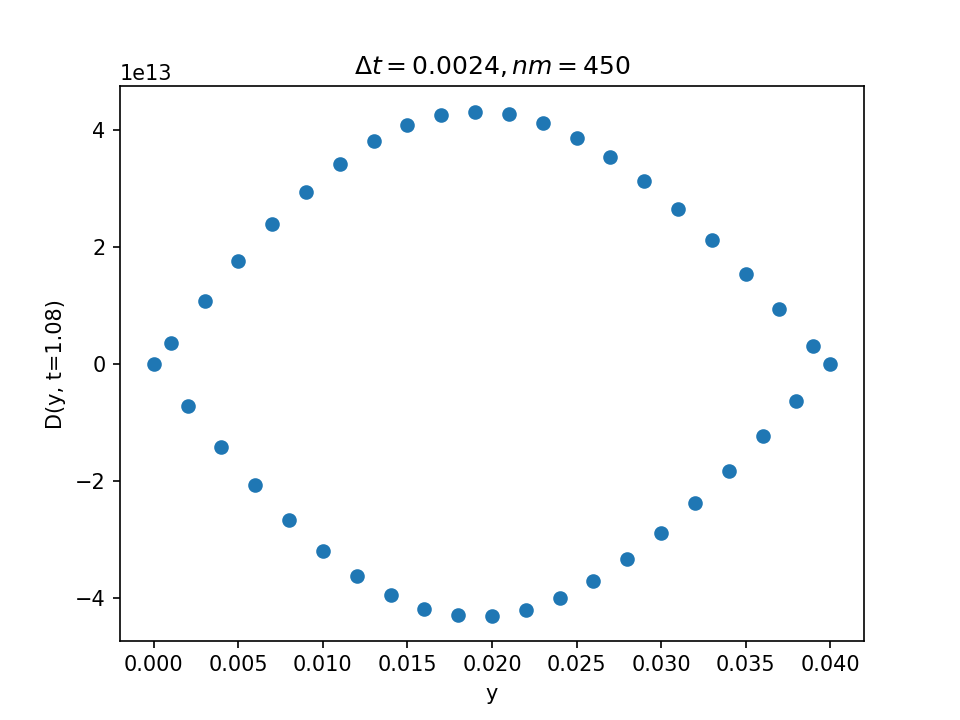

In [18]:
# Error plots: t = 0.18, t=1.08 - compare to trial 1, 3
# time indices
t0ind = int(0.18/dt)
t1ind = -1

# error data
t0err = FTCS2err[:,t0ind]
t1err = FTCS2err[:,t1ind]


# ABSOLUTE DISCRETIZATION ERROR CALCULATION
abs_t0FTCS2err = np.sum(np.abs(t0err))
print(f't=0.18 abs DE = {abs_t0FTCS2err}')
abs_t1FTCS2err = np.sum(np.abs(t1err))
print(f't=1.08 abs DE = {abs_t1FTCS2err}')
# END OF ADEC


y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t0err)
plt.title('$\Delta t = 0.0024, nm = 450$')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('FTCS T2 t=0.18.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.0024, nm = 450$')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('FTCS T2 t=1.08.png')

### Trial 3: dt = 0.001, nm = 1080 & dy = 0.0008, jm = 50. (STABLE)

In [19]:
dt = 0.001
nm = 1080
dy = 0.0008
jm = 50

In [20]:
# Get solution
FTCSuSOL3 = FTCS(dt=dt, nm=nm, dy=dy, jm=jm)

In [21]:
# Print solution: overflow
FTCSuSOL3[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [38.81751353, 38.81804524, 38.81857614, 38.81910623],
       [37.63659525, 37.63765627, 37.63871566, 37.63977343],
       [36.45880626, 36.46039177, 36.46197485, 36.4635555 ],
       [35.28569344, 35.28779626, 35.28989587, 35.29199225],
       [34.1187825 , 34.12139313, 34.12399977, 34.12660242],
       [32.95957112, 32.96267777, 32.96577969, 32.96887688],
       [31.80952222, 31.81311093, 31.81669417, 31.82027197],
       [30.67005752, 30.67411218, 30.67816069, 30.68220307],
       [29.54255125, 29.54705374, 29.55154943, 29.55603834],
       [28.4283242 , 28.43325448, 28.43817736, 28.44309284],
       [27.32863807, 27.33397431, 27.33930257, 27.34462286],
       [26.24469015, 26.25040881, 26.25611898, 26.26182066],
       [25.17760833, 25.18368435, 25.1897514 , 25.19580949],
       [24.12844659, 24.1348535 , 24.141251  , 24.14763911],
       [23.0981808 , 23.10489085, 23.11159112, 23.11828161],
       [22.08770503, 22.

In [22]:
# Calculating error matrix: EXPLODES --> Check stability ratio
FTCS3err = err_matrix(FTCSuSOL3, dt=dt, nm=nm, dy=dy, jm=jm)
FTCS3err[:,-4:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00072926, -0.00072832, -0.00072739, -0.00072646],
       [-0.00145515, -0.00145329, -0.00145143, -0.00144958],
       [-0.00217433, -0.00217156, -0.00216879, -0.00216603],
       [-0.00288351, -0.00287984, -0.00287617, -0.00287251],
       [-0.00357943, -0.00357489, -0.00357035, -0.00356582],
       [-0.00425895, -0.00425356, -0.00424818, -0.00424281],
       [-0.00491902, -0.00491281, -0.00490662, -0.00490044],
       [-0.00555668, -0.0055497 , -0.00554274, -0.00553578],
       [-0.00616915, -0.00616144, -0.00615374, -0.00614605],
       [-0.00675377, -0.00674537, -0.00673699, -0.00672862],
       [-0.00730805, -0.00729902, -0.00729   , -0.007281  ],
       [-0.0078297 , -0.00782009, -0.00781048, -0.0078009 ],
       [-0.0083166 , -0.00830646, -0.00829633, -0.00828621],
       [-0.00876683, -0.00875621, -0.00874561, -0.00873503],
       [-0.00917867, -0.00916765, -0.00915663, -0.00914563],
       [-0.00955064, -0.

t=0.18 abs DE = 1.0126341591852952
t=1.08 abs DE = 0.3477322316884349


<IPython.core.display.Javascript object>


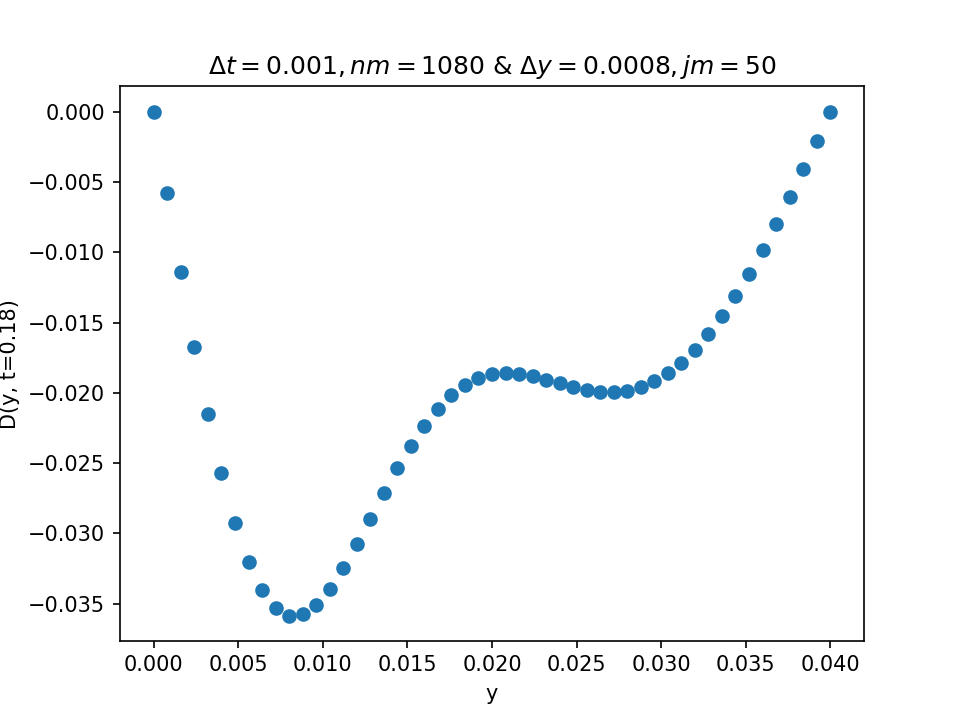

<IPython.core.display.Javascript object>


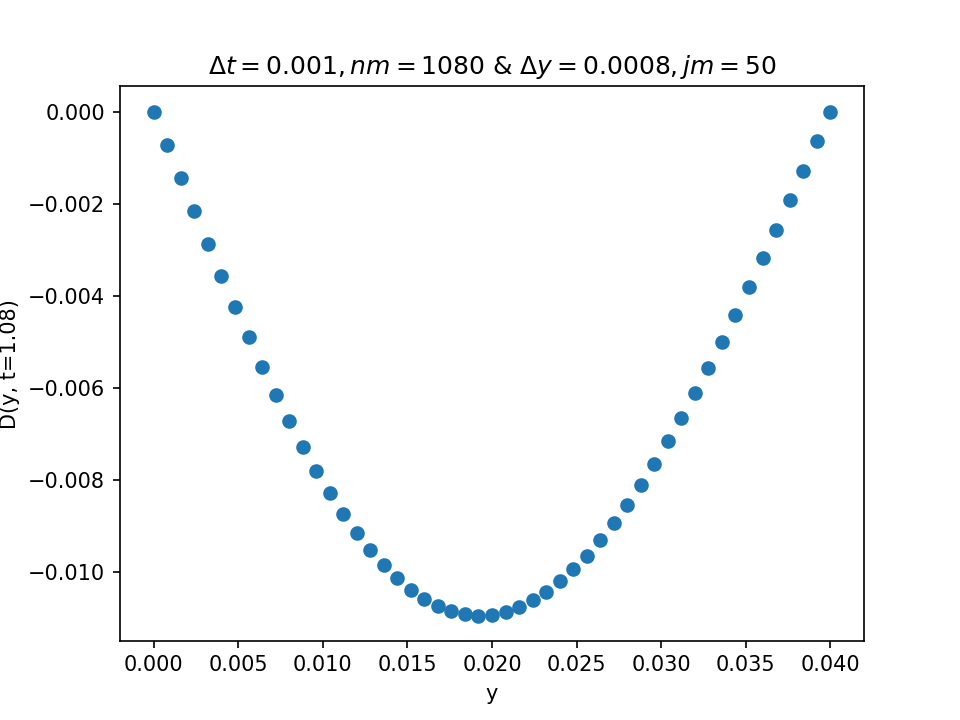

In [23]:
# Error plots: t=0.18, t=1.08  - compare to trials 1, 2
# time indices
t0ind = int(0.18/dt)
t1ind = -1

# error data
t0err = FTCS3err[:,t0ind]
t1err = FTCS3err[:,t1ind]


# ABSOLUTE DISCRETIZATION ERROR CALCULATION
abs_t0FTCS3err = np.sum(np.abs(t0err))
print(f't=0.18 abs DE = {abs_t0FTCS3err}')
abs_t1FTCS3err = np.sum(np.abs(t1err))
print(f't=1.08 abs DE = {abs_t1FTCS3err}')
# END OF ADEC


y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t0err)
plt.title('$\Delta t = 0.001, nm = 1080$ & $\Delta y = 0.0008, jm = 50$')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('FTCS T3 t=0.18.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.001, nm = 1080$ & $\Delta y = 0.0008, jm = 50$')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('FTCS T3 t=1.08.png')

### Trial 4: dt = 0.001, nm = 1080 & dy = 0.0005, jm = 80.

In [24]:
dt = 0.001
nm = 1080
dy = 0.0005
jm = 80

In [25]:
# Get solution: Cannot compute it - answers explore so rapidly that there is overflow. 
FTCSuSOL4 = FTCS(dt=dt, nm=nm, dy=dy, jm=jm)

C:\Users\oloth\AppData\Local\Temp\ipykernel_108252\3554853326.py:12: RuntimeWarning: overflow encountered in add
  uSOL[1:-1, n] = alpha*uSOL[2:,n-1] + (1 - 2*alpha)*uSOL[1:-1, n-1] + alpha*uSOL[0:-2,n-1] # j+1, j, and j-1th terms


In [26]:
# mention it explodes; overflow: in comparison to trials 1, 2, 3.

## 3. DuFort-Frankel Explicit

The DuFort-Frankel Scheme is a central time central space approximation, also replacing the $u_j^n$ entry with the average of $u_j^{n+1}$ and $u_j^{n-1}$ such that one obtains the two step scheme,

$\frac{u_{j}^{n+1} - u_j^{n-1}}{2\Delta t} = \frac{\nu}{(\Delta y)^2} [u_{j+1}^{n} - 2(\frac{u_j^{n+1} + u_j^{n-1}}{2}) + u_{j-1}^n] = \frac{\nu}{(\Delta y)^2} [u_{j+1}^{n} - (u_j^{n+1} + u_j^{n-1}) + u_{j-1}^n]$

Rearranging,

$u_{j}^{n+1} - u_j^{n-1} = \frac{\nu 2 \Delta t}{(\Delta y)^2} [u_{j+1}^{n} - (u_j^{n+1} + u_j^{n-1}) + u_{j-1}^n] = \beta [u_{j+1}^{n} - (u_j^{n+1} + u_j^{n-1}) + u_{j-1}^n]\;\;\;\;\;\;\;\;\; \text{where } \beta = \frac{\nu 2 \Delta t}{(\Delta y)^2}$

$\Rightarrow (1 + \beta)u_{j}^{n+1} = \beta u_{j+1}^n + \beta u_{j-1}^n + (1 - \beta)u_j^{n-1}$

and so

$u_{j}^{n+1} = \frac{\beta}{1 + \beta} u_{j+1}^n + \frac{\beta}{1 + \beta} u_{j-1}^n + \frac{1 - \beta}{1 + \beta}u_j^{n-1}$

#### Note
As this is a two step method, it is not possible to immediately apply the Du-Fort Frankel scheme since only one initial condition is given. Thus, the first time step will be calculated using the FTCS method, after which the Du-Fort Frankel scheme can be implemented.

### Coding up the algorithm

In [103]:
def DuFF(dt, nm, dy, jm):
    # Define empty solution matrix
    uSOL = np.zeros((jm+1,nm+1)) #row = y grid evaluations, column represents time from 0->1.08s
    uSOL[:,0] = np.linspace(0, jm*dy, jm+1) # initial condition
    uSOL[0,:] = U0 # boundary condition -> u(y=h, t) = 0 already satisfied
    
    # Define alpha and beta coefficient
    alpha = v*dt / dy**2
    beta = v*2*dt / dy**2
    
    # Iterate through time, using FTCS for the first time step (n=0 -> n=1)
    for n in range(1, nm+1):
        # First time step with FTCS
        if n==1:
            uSOL[1:-1,n] = alpha*uSOL[2:, n-1] + (1 - 2*alpha)*uSOL[1:-1,n-1] + alpha*uSOL[0:-2,n-1] # j+1, j, and j-1th terms
        
        # Du-Fort Frankel for remaining steps
        else:
            uSOL[1:-1,n] = (beta/(1+beta))*uSOL[2:,n-1] + (beta/(1+beta))*uSOL[0:-2,n-1] + (1-beta)/(1+beta)*uSOL[1:-1,n-2] # j+1, j-1, and jth terms
    
    return uSOL

### Trial 1: dt = 0.002, nm = 540 & back to dy = 0.001, jm = 40.

In [160]:
dt = 0.002 # s
nm = 540 # s, steps in time (nm + 1 time points)
dy = 0.001
jm = 40

In [161]:
# Get solution
DuFFuSOL1 = DuFF(dt=dt, nm=nm, dy=dy, jm=jm)

In [162]:
# Print solution
DuFFuSOL1[:,-4:] # unstable, due to the first FTCS step - since the Du-Fort Frankel scheme itself is unconditionally stable

array([[40.        , 40.        , 40.        , 40.        ],
       [38.52100398, 38.5211782 , 38.52366232, 38.52383547],
       [37.04276299, 37.04772891, 37.04807503, 37.0530105 ],
       [35.575262  , 35.57577969, 35.58316187, 35.58367638],
       [34.11000467, 34.11979619, 34.12047861, 34.13021036],
       [32.66592383, 32.66677034, 32.67884257, 32.6796839 ],
       [31.22551185, 31.23985355, 31.24085301, 31.25510783],
       [29.81611719, 29.81726867, 29.83369286, 29.83483737],
       [28.41171344, 28.43020497, 28.43149347, 28.44987415],
       [27.04730196, 27.04872629, 27.06904661, 27.07046242],
       [25.68906447, 25.71119503, 25.71273687, 25.73473654],
       [24.37868946, 24.3803474 , 24.40400652, 24.40565469],
       [23.07550165, 23.10066806, 23.10242109, 23.12744101],
       [21.82674196, 21.82858851, 21.85494696, 21.85678282],
       [20.58598788, 20.61351509, 20.61543217, 20.64280208],
       [19.4047676 , 19.40675353, 19.43511099, 19.43708567],
       [18.23215816, 18.

In [163]:
# Calculating error matrix
DuFF1err = err_matrix(DuFFuSOL1, dt=dt, nm=nm, dy=dy, jm=jm)
DuFF1err[:,-4:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00184212, -0.00068014, -0.00183219, -0.00067734],
       [-0.00135756, -0.00366058, -0.00135198, -0.00364089],
       [-0.00547145, -0.00201842, -0.00544206, -0.00201018],
       [-0.00267121, -0.0072123 , -0.00266037, -0.00717376],
       [-0.00893828, -0.00329173, -0.0088907 , -0.0032785 ],
       [-0.00389916, -0.01055084, -0.00388364, -0.01049507],
       [-0.01214182, -0.00446022, -0.01207802, -0.00444272],
       [-0.00500369, -0.01358064, -0.00498435, -0.01350992],
       [-0.014992  , -0.00548898, -0.01491457, -0.00546816],
       [-0.00595287, -0.01621858, -0.00593072, -0.01613573],
       [-0.01741283, -0.00634952, -0.0173248 , -0.00632642],
       [-0.00672174, -0.01839683, -0.00669788, -0.01830503],
       [-0.01934481, -0.00702072, -0.01924948, -0.00699647],
       [-0.00729313, -0.02006484, -0.00726866, -0.01996741],
       [-0.02074639, -0.00748939, -0.0206471 , -0.00746507],
       [-0.00765784, -0.

t=0.18 abs DE = 1.010700808816487
t=1.08 abs DE = 0.37411265309958486


<IPython.core.display.Javascript object>


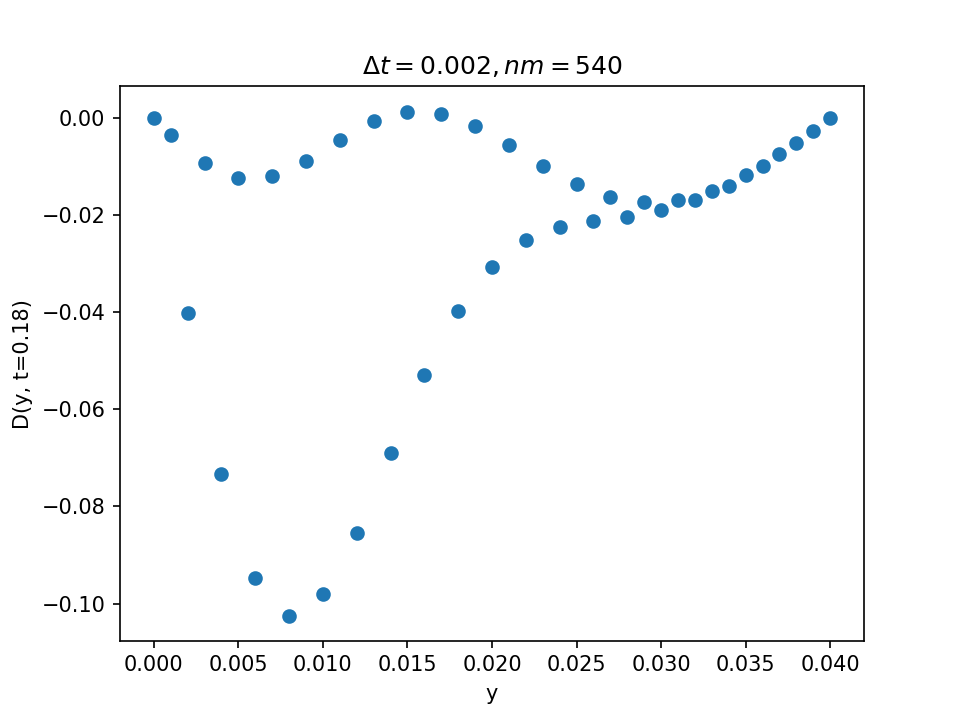

<IPython.core.display.Javascript object>


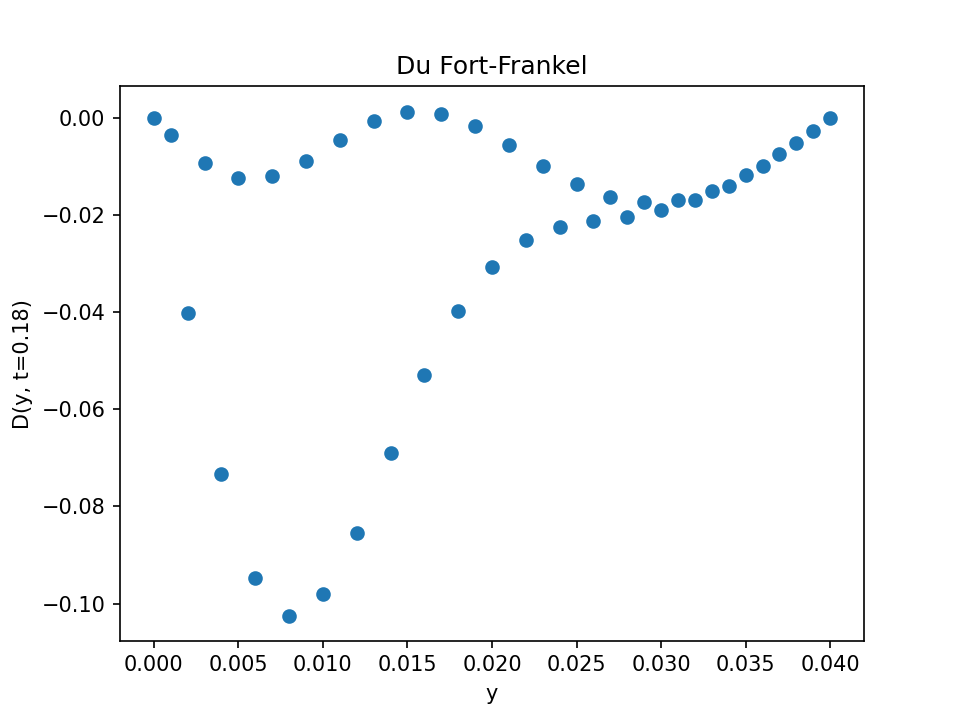

<IPython.core.display.Javascript object>


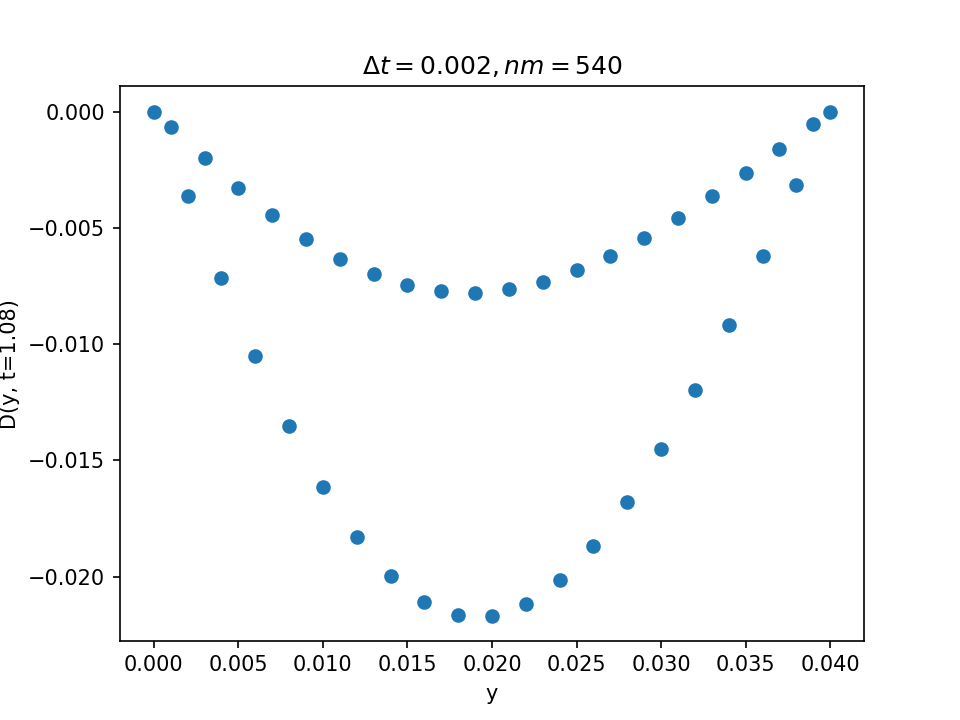

<IPython.core.display.Javascript object>


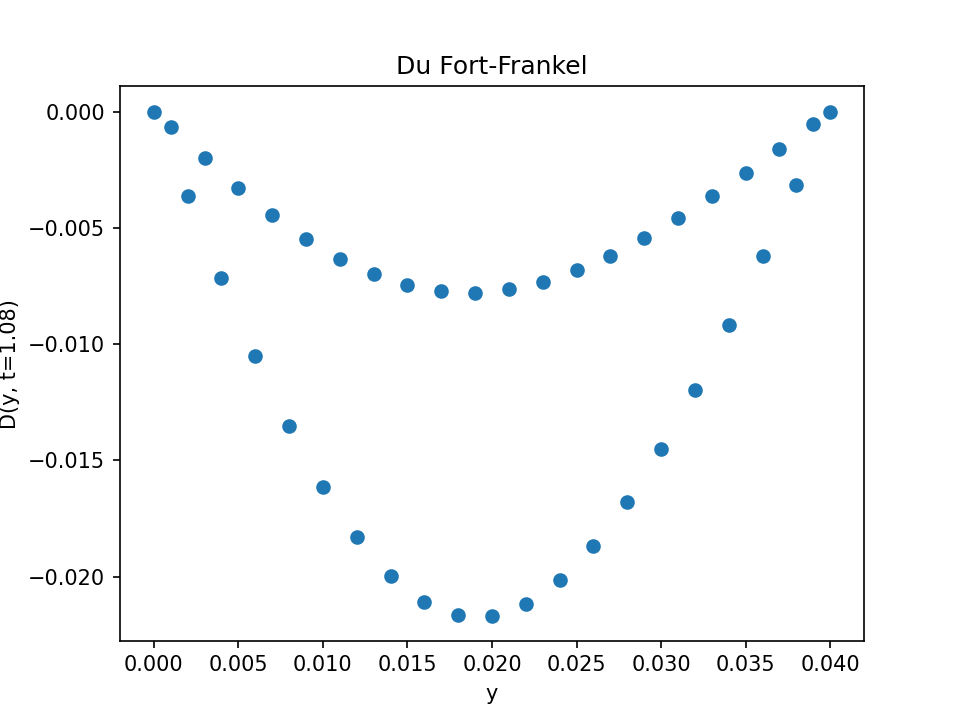

In [164]:
# Error plots: t=0.18, t=1.08 - compare to other methods and trial 2, 3
# time indices
t0ind = int(0.18/dt)
t1ind = -1

# error data
t0err = DuFF1err[:,t0ind]
t1err = DuFF1err[:,t1ind]


# ABSOLUTE DISCRETIZATION ERROR CALCULATION
abs_t0DuFF1err = np.sum(np.abs(t0err))
print(f't=0.18 abs DE = {abs_t0DuFF1err}')
abs_t1DuFF1err = np.sum(np.abs(t1err))
print(f't=1.08 abs DE = {abs_t1DuFF1err}')
# END OF ADEC


y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t0err)
plt.title('$\Delta t = 0.002, nm = 540$')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('DuFF T1 t=0.18.png')

plt.figure()
plt.scatter(y, t0err)
plt.title('Du Fort-Frankel')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('DuFF t=0.18.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.002, nm = 540$')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('DuFF T1 t=1.08.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('Du Fort-Frankel')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('DuFF t=1.08.png')

### Trial 2: dt = 0.003, nm = 360

In [114]:
dt = 0.003 # s
nm = 360 # s, steps in time (nm + 1 time points)

In [115]:
# Get solution
DuFFuSOL2 = DuFF(dt=dt, nm=nm, dy=dy, jm=jm)

In [116]:
# Print solution
DuFFuSOL2[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [38.52093322, 38.52032085, 38.5249183 , 38.52431155],
       [37.03970744, 37.04891226, 37.04769746, 37.05681775],
       [35.57504061, 35.57322077, 35.58688351, 35.58508035],
       [34.10395778, 34.1221078 , 34.1197124 , 34.13769651],
       [32.66552581, 32.66254973, 32.6848937 , 32.68194473],
       [31.21660158, 31.2431872 , 31.23967837, 31.26602279],
       [29.81550337, 29.81145432, 29.84185515, 29.83784266],
       [28.40013041, 28.43441079, 28.42988615, 28.46385872],
       [27.04642585, 27.04141611, 27.07903182, 27.07406677],
       [25.67506017, 25.71608987, 25.71067405, 25.75134018],
       [24.37750447, 24.37167132, 24.4154722 , 24.40969034],
       [23.05938559, 23.10604787, 23.09988809, 23.14614338],
       [21.82520927, 21.81871027, 21.86751438, 21.86107156],
       [20.56812344, 20.61916818, 20.6124293 , 20.66303686],
       [19.40286381, 19.39587154, 19.44838397, 19.44145098],
       [18.21295696, 18.

In [117]:
# Calculating error matrix
DuFF2err = err_matrix(DuFFuSOL2, dt=dt, nm=nm, dy=dy, jm=jm)
DuFF2err[:,-4:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00378341, -0.00115899, -0.00375369, -0.00115343],
       [-0.00231179, -0.00750682, -0.00230074, -0.00744814],
       [-0.0112291 , -0.00343022, -0.01114145, -0.00341414],
       [-0.00453023, -0.01477434, -0.00450933, -0.01465992],
       [-0.01831716, -0.00556418, -0.01817599, -0.00553932],
       [-0.00656789, -0.02157451, -0.00653942, -0.02141003],
       [-0.02482791, -0.00747895, -0.02464018, -0.00744801],
       [-0.00834864, -0.02770104, -0.00831571, -0.0274945 ],
       [-0.03056836, -0.00910615, -0.03034308, -0.00907251],
       [-0.00981211, -0.03297828, -0.00977836, -0.03273937],
       [-0.03538016, -0.01039469, -0.03512773, -0.01036208],
       [-0.01091675, -0.03726797, -0.01088596, -0.0370074 ],
       [-0.03914518, -0.01131312, -0.03887663, -0.01128521],
       [-0.01164143, -0.04047342, -0.01161715, -0.04020219],
       [-0.04178828, -0.01185033, -0.04151456, -0.01183038],
       [-0.01198524, -0.

t=0.18 abs DE = 1.8265296677525353
t=1.08 abs DE = 0.6948550593458209


<IPython.core.display.Javascript object>


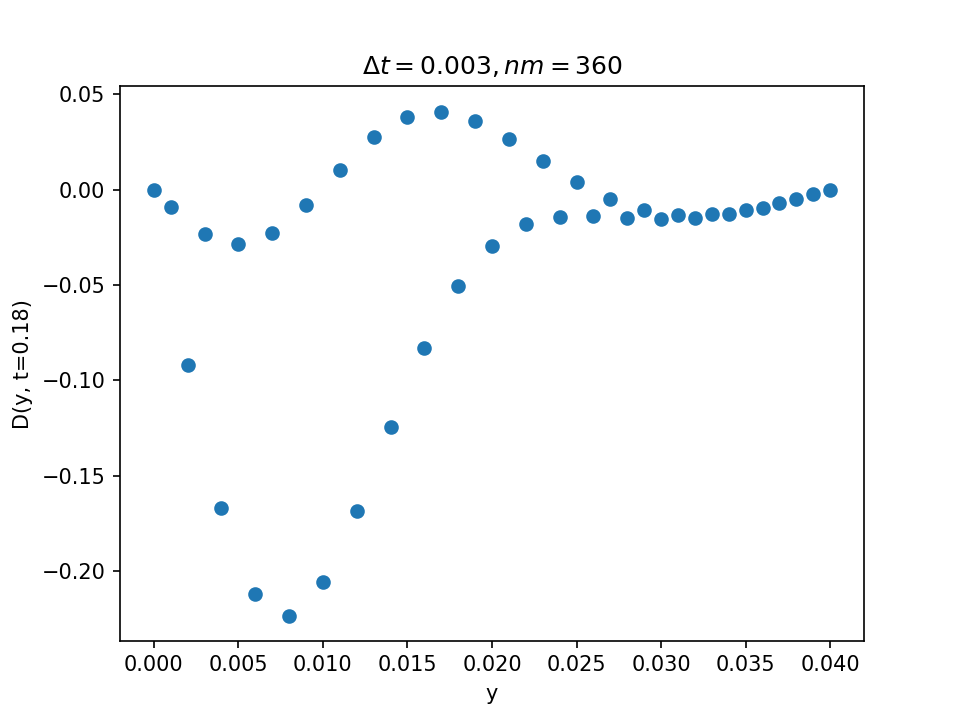

<IPython.core.display.Javascript object>


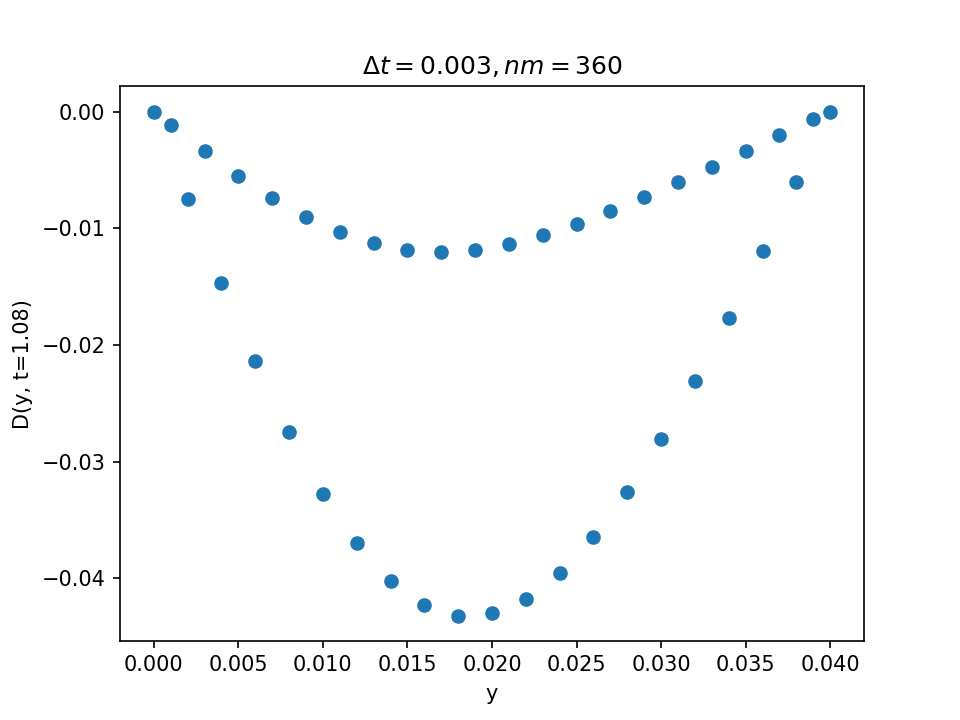

In [118]:
# Error plots: t=0.18, t=1.08 - compare to trials 1, 3
# time indices
t0ind = int(0.18/dt)
t1ind = -1

# error data
t0err = DuFF2err[:,t0ind]
t1err = DuFF2err[:,t1ind]


# ABSOLUTE DISCRETIZATION ERROR CALCULATION
abs_t0DuFF2err = np.sum(np.abs(t0err))
print(f't=0.18 abs DE = {abs_t0DuFF2err}')
abs_t1DuFF2err = np.sum(np.abs(t1err))
print(f't=1.08 abs DE = {abs_t1DuFF2err}')
# END OF ADEC


y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t0err)
plt.title('$\Delta t = 0.003, nm = 360$')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('DuFF T2 t=0.18.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.003, nm = 360$')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('DuFF T2 t=1.08.png')

### Trial 3: dt = 0.001, nm = 1080.

In [119]:
dt = 0.001
nm = 1080

In [120]:
# Get solution
DuFFuSOL3 = DuFF(dt=dt, nm=nm, dy=dy, jm=jm)

In [121]:
# Print solution
DuFFuSOL3[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [38.52184692, 38.52222272, 38.52317493, 38.52354958],
       [37.0461812 , 37.0480818 , 37.04882958, 37.05072434],
       [35.57777356, 35.57889031, 35.58172002, 35.58283334],
       [34.11675753, 34.12050499, 34.12197939, 34.12571539],
       [32.67005239, 32.67187852, 32.67650589, 32.67832645],
       [31.23543427, 31.2409231 , 31.24308258, 31.24855476],
       [29.82177692, 29.82426115, 29.83055644, 29.83303317],
       [28.42456269, 28.43163957, 28.43442375, 28.44147939],
       [27.05437344, 27.05744664, 27.06523494, 27.06829895],
       [25.70452597, 25.7129953 , 25.71632718, 25.72477143],
       [24.3870206 , 24.39059825, 24.39966575, 24.40323289],
       [23.09319654, 23.10282736, 23.10661602, 23.11621877],
       [21.83614954, 21.84013475, 21.85023616, 21.85420985],
       [20.60548214, 20.61601599, 20.6201597 , 20.63066342],
       [19.41503965, 19.41932634, 19.43019309, 19.43446764],
       [18.25297311, 18.

In [122]:
# Calculating error matrix
DuFF3err = err_matrix(DuFFuSOL3, dt=dt, nm=nm, dy=dy, jm=jm)
DuFF3err[:,-4:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00068231, -0.00039258, -0.00068029, -0.00039146],
       [-0.00078448, -0.00135875, -0.00078223, -0.00135473],
       [-0.00203151, -0.00117051, -0.0020255 , -0.00116713],
       [-0.00155447, -0.00268675, -0.00154997, -0.00267879],
       [-0.00333467, -0.00192665, -0.00332479, -0.00192105],
       [-0.00229532, -0.00395374, -0.00228861, -0.003942  ],
       [-0.00456194, -0.00264631, -0.00454838, -0.00263852],
       [-0.00299225, -0.00513045, -0.00298338, -0.00511517],
       [-0.0056847 , -0.0033146 , -0.00566773, -0.00330469],
       [-0.00363027, -0.00618914, -0.00361933, -0.00617063],
       [-0.00667613, -0.00391654, -0.00665611, -0.00390462],
       [-0.00419442, -0.00710415, -0.00418153, -0.00708279],
       [-0.00751179, -0.00443727, -0.00748915, -0.0044235 ],
       [-0.00467   , -0.00785249, -0.00465536, -0.00782875],
       [-0.00817025, -0.00486246, -0.00814548, -0.00484705],
       [-0.00504307, -0.

t=0.18 abs DE = 0.7526605766433354 and average 0.018357575040081352
t=1.08 abs DE = 0.18188704580132886 and average 0.004436269409788509


<IPython.core.display.Javascript object>


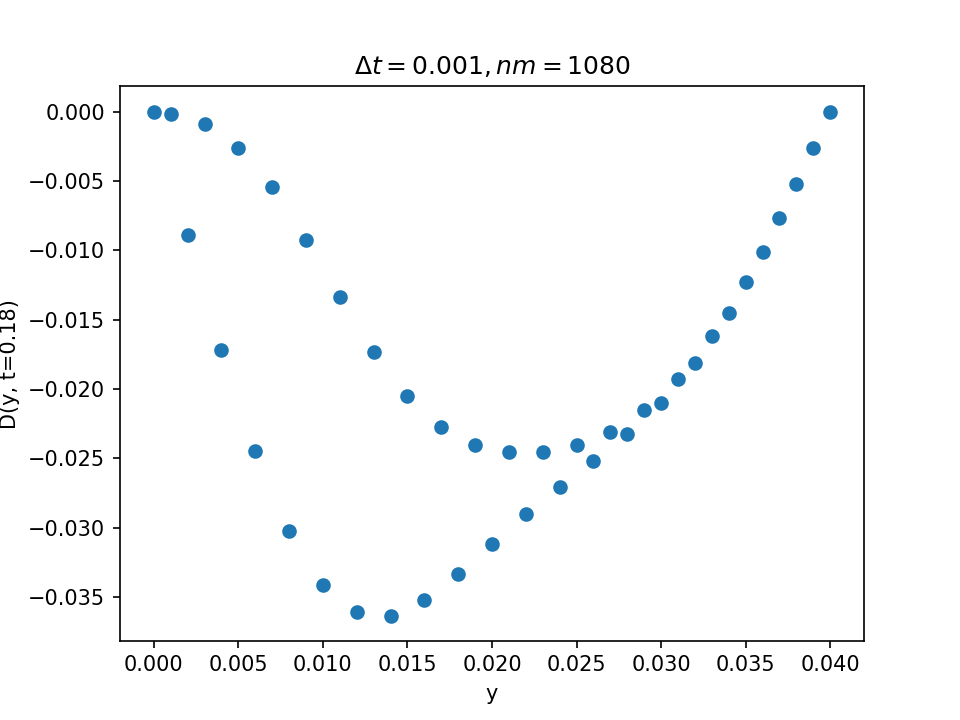

<IPython.core.display.Javascript object>


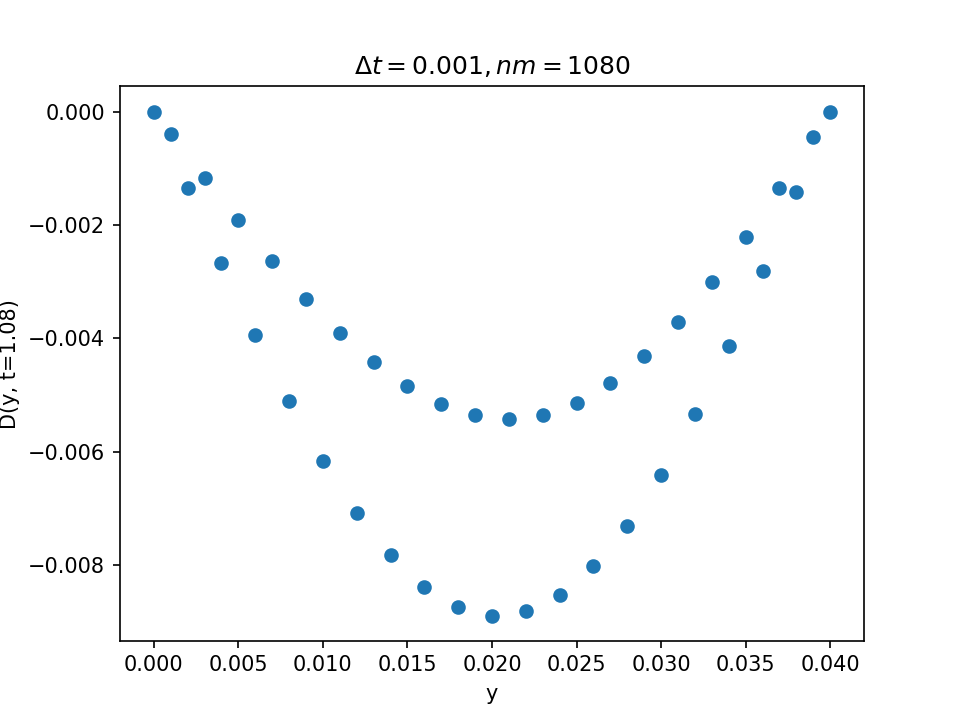

In [123]:
# Error plots: t=0.18, t=1.08 - compare to trials 1, 2 & inconsistent 3
# time indices
t0ind = int(0.18/dt)
t1ind = -1

# error data
t0err = DuFF3err[:,t0ind]
t1err = DuFF3err[:,t1ind]


# ABSOLUTE DISCRETIZATION ERROR CALCULATION
abs_t0DuFF3err = np.sum(np.abs(t0err))
print(f't=0.18 abs DE = {abs_t0DuFF3err} and average {abs_t0DuFF3err/(jm+1)}')
abs_t1DuFF3err = np.sum(np.abs(t1err))
print(f't=1.08 abs DE = {abs_t1DuFF3err} and average {abs_t1DuFF3err/(jm+1)}')
# END OF ADEC


y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t0err)
plt.title('$\Delta t = 0.001, nm = 1080$')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('DuFF T3 t=0.18.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.001, nm = 1080$')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('DuFF T3 t=1.08.png')

In [124]:
print(dy)

0.001


### Trial 4: dt = 0.002, nm = 540 & dy = 0.002, jm = 20

In [125]:
dt = 0.002
nm = 540
dy = 0.002
jm = 20

In [126]:
# Get solution
DuFFuSOL4 = DuFF(dt=dt, nm=nm, dy=dy, jm=jm)
DuFFuSOL4[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [37.0417629 , 37.04384724, 37.04707437, 37.04914589],
       [34.10693183, 34.1133141 , 34.1174109 , 34.12375417],
       [31.22276798, 31.22878614, 31.23810483, 31.24408645],
       [28.40618562, 28.41823545, 28.42597002, 28.43794758],
       [25.68525965, 25.69454184, 25.7089175 , 25.7181447 ],
       [23.0685715 , 23.08496402, 23.09548546, 23.11178258],
       [20.58200453, 20.5935426 , 20.61141694, 20.62288907],
       [18.22501297, 18.24399852, 18.25618337, 18.27506278],
       [16.01871193, 16.03129616, 16.05079765, 16.06331312],
       [13.95374065, 13.97337154, 13.98596951, 14.00549578],
       [12.04456589, 12.05693405, 12.07610762, 12.08841156],
       [10.27430043, 10.29265555, 10.30443377, 10.32269602],
       [ 8.64969108,  8.66066348,  8.6776793 ,  8.68859765],
       [ 7.14832029,  7.16369276,  7.17355625,  7.18885479],
       [ 5.76892484,  5.77750782,  5.79082228,  5.79936498],
       [ 4.48593441,  4.

In [127]:
# Calculating error matrix
DuFF4err = err_matrix(DuFFuSOL4, dt=dt, nm=nm, dy=dy, jm=jm)
DuFF4err[:,-4:]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.57464367e-04,  2.21097498e-04, -3.51318658e-04,
         2.23717633e-04],
       [ 4.01627720e-04, -7.30211590e-04,  4.07342148e-04,
        -7.17573708e-04],
       [-1.15528954e-03,  5.16569398e-04, -1.13547121e-03,
         5.26313432e-04],
       [ 5.24131105e-04, -1.61112743e-03,  5.39098040e-04,
        -1.58335443e-03],
       [-2.14805948e-03,  4.34616053e-04, -2.11134316e-03,
         4.56107123e-04],
       [ 2.08410155e-04, -2.69278578e-03,  2.37747146e-04,
        -2.64659880e-03],
       [-3.30977464e-03, -9.23537899e-05, -3.25343532e-03,
        -5.43921527e-05],
       [-5.12653368e-04, -3.86742730e-03, -4.65320028e-04,
        -3.80143019e-03],
       [-4.45211626e-03, -9.33696902e-04, -4.37664962e-03,
        -8.77551234e-04],
       [-1.41904484e-03, -4.88159287e-03, -1.35443507e-03,
        -4.79868615e-03],
       [-5.27251887e-03, -1.80467312e-03, -5.18350106e-03,
      

t=0.18 abs DE = 0.6441398071145149 and average 0.030673324148310234
t=1.08 abs DE = 0.041097216049241325 and average 0.0019570102880591108


<IPython.core.display.Javascript object>


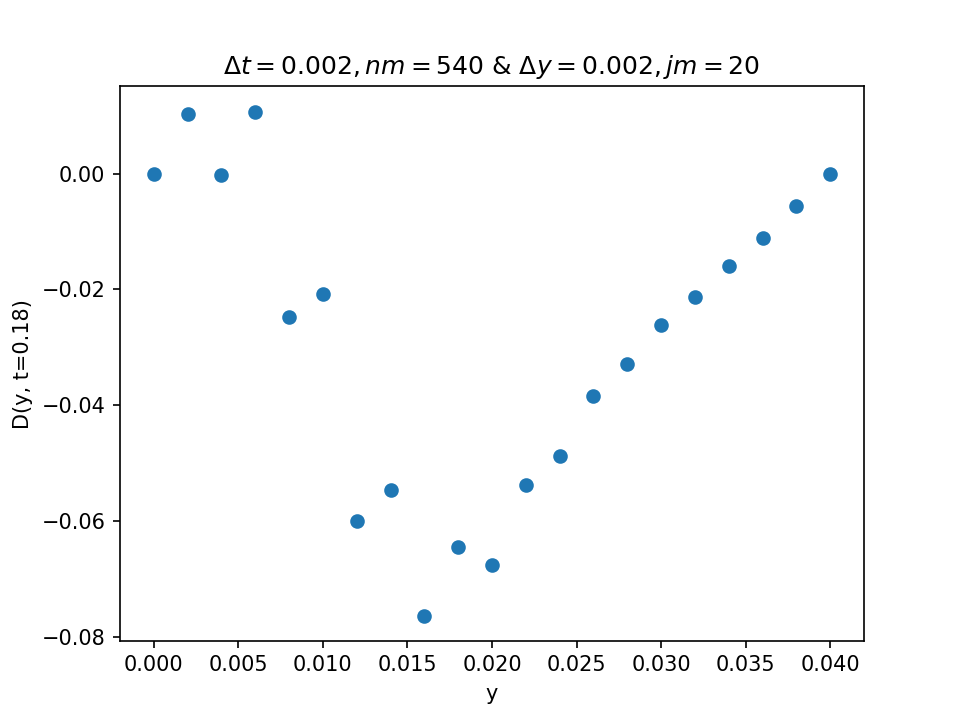

<IPython.core.display.Javascript object>


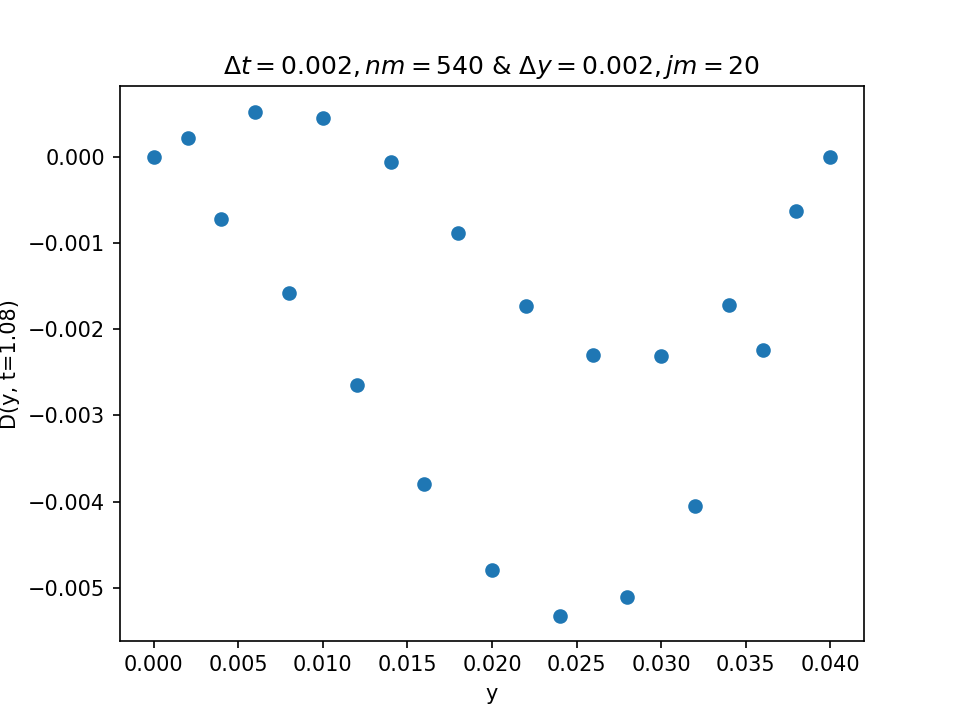

In [128]:
# Error plots: t=0.18, t=1.08 - compare to trials 1, 2 
# time indices
t0ind = int(0.18/dt)
t1ind = -1

# error data
t0err = DuFF4err[:,t0ind]
t1err = DuFF4err[:,t1ind]


# ABSOLUTE DISCRETIZATION ERROR CALCULATION
abs_t0DuFF4err = np.sum(np.abs(t0err))
print(f't=0.18 abs DE = {abs_t0DuFF4err} and average {abs_t0DuFF4err/(jm+1)}')
abs_t1DuFF4err = np.sum(np.abs(t1err))
print(f't=1.08 abs DE = {abs_t1DuFF4err} and average {abs_t1DuFF4err/(jm+1)}')
# END OF ADEC


y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t0err)
plt.title('$\Delta t = 0.002, nm = 540$ & $\Delta y = 0.002, jm = 20$')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('DuFF T4 t=0.18.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.002, nm = 540$ & $\Delta y = 0.002, jm = 20$')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('DuFF T4 t=1.08.png')

## 4. Laasonen Implicit

The Laasonen method is an implicit scheme with backward time central space approximations, such that the PDE becomes

$\frac{u_{j}^{n+1} - u_j^{n}}{\Delta t} = \frac{\nu}{(\Delta y)^2} [u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1}]$

Rearranging to obtain a tridiagonal system,

$u_{j}^{n+1} - u_j^{n} = \frac{\nu \Delta t}{(\Delta y)^2} [u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1}] = \alpha [u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1}]\;\;\;\;\;\;\; \text{where } \alpha=\frac{\nu \Delta t}{(\Delta y)^2}$

$\Rightarrow -\alpha u_{j-1}^{n+1} + (1 + 2\alpha)u_j^{n+1} - \alpha u_{j+1}^{n+1} = u_j^n$

which creates a linear system of equations $Au=b$ for $y$ indices $j=1,...,jm-1$, where $A$ is a tridiagonal matrix. The cases $j=0$ and $j=jm$ as excluded they are not required to solve the system (and include points outside of the problem domain). The $n$ index ranges from $n = 1, ..., nm$ as expected, with $n=0$ being the initial condition at time $t=0$.

#### Note
The cases $j=1$ and $j=jm$ are special as they include the boundary conditions, such that 

For $j = 1$:
- $(1 + 2\alpha)u_{1}^{n+1} - \alpha u_{2}^{n+1} = u_1^n + \alpha u_0^{n+1} = u_1^n + \alpha U_0, \;\;\;\;\;\;\;\; \text{as } u_{0}^n = U_0$

For $j = jm - 1$:
- $- \alpha u_{jm-2}^{n+1} + (1 + 2\alpha)u_{jm-1}^{n+1} = u_{jm-1}^n + \alpha u_{jm}^{n+1} = u_{jm-1}^n, \;\;\;\;\;\;\;\; \text{as } u_{jm}^n = 0$

### Coding the algorithm (Matrix Inversion)

In [47]:
def L(dt, nm, dy, jm):
    # Define empty solution matrix with initial and boundary conditions
    uSOL = np.zeros((jm+1,nm+1))
    uSOL[:,0] = np.linspace(0, jm*dy, jm+1)
    uSOL[0,:] = U0
    
    alpha = v*dt/dy**2
    
    for n in range(1, nm +1):
        # // Build tridiagonal matrix system //
        # uppder and lower diagonal
        ud = np.array([-alpha]*(jm-1)) # excluding j=0 and jm, i.e. only j=1, ..., jm-1
        ld = ud 
        
        # diagonal
        d = np.array([1 + 2*alpha]*(jm-1)) # same here

        # Creating matrix A
        A = np.zeros((jm-1,jm-1))
        
        for i in range((jm-1)-1): # excluding last main diagonal element
            A[i][i] = d[i]
            A[i+1][i] = ld[i]
            A[i][i+1] = ud[i]
        
        A[-1,-1] = d[-1] # indices -1 and jm-2 are interchangeable here, this is the last diagonal element

        # Defining constant matrix b
        b = np.zeros(jm-1)
        
        # j = 1 boundary value case
        b[0] = uSOL[1,n-1] + alpha*U0
        
        # j > 1 up to and including jm-1 (last boundary included as the boundary value is zero)
        b[1:] = uSOL[2:-1,n-1]
        
        # // Solve for u at next time
        uSOL[1:-1,n] = np.linalg.solve(A, b) # u_j= 0 and u_jm have BCs so solve for j = 1, ..., jm-1
    
    return uSOL

### Trial 1: dt = 0.002, nm = 540

In [147]:
dt = 0.002 # s
nm = 540 # s, steps in time (nm + 1 time points)
dy = 0.001
jm = 40

In [148]:
# Calculate solution
LuSOL1 = L(dt=dt, nm=nm, dy=dy, jm=jm)
LuSOL1[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [38.51835156, 38.51968921, 38.52102273, 38.52235215],
       [37.0397948 , 37.04246056, 37.04511811, 37.04776748],
       [35.56739934, 35.57137421, 35.57533687, 35.57928736],
       [34.10419084, 34.10944656, 34.11468617, 34.11990974],
       [32.65312956, 32.65962887, 32.66610832, 32.672568  ],
       [31.21708956, 31.22478652, 31.23246008, 31.24011032],
       [29.79883864, 29.80767912, 29.81649284, 29.82527993],
       [28.40101935, 28.41094146, 28.42083373, 28.43069627],
       [27.0261311 , 27.03706582, 27.04796786, 27.05883734],
       [25.67651362, 25.68838537, 25.70022189, 25.71202332],
       [24.35433184, 24.36705915, 24.37974901, 24.39240156],
       [23.06156228, 23.07505855, 23.08851545, 23.10193311],
       [21.79998118, 21.81415535, 21.82828856, 21.84238093],
       [20.57115419, 20.58591154, 20.60062665, 20.61529967],
       [19.37642795, 19.39167082, 19.40687053, 19.42202721],
       [18.21692332, 18.

In [149]:
# Calculating error matrix
L1err = err_matrix(LuSOL1, dt=dt, nm=nm, dy=dy, jm=jm)
L1err[:,-4:]

array([[0.        , 0.        , 0.        , 0.        ],
       [0.0008103 , 0.00080885, 0.0008074 , 0.00080597],
       [0.00161063, 0.00160778, 0.00160494, 0.00160213],
       [0.00239121, 0.00238706, 0.00238294, 0.00237885],
       [0.00314262, 0.00313733, 0.00313207, 0.00312685],
       [0.00385599, 0.00384975, 0.00384355, 0.0038374 ],
       [0.00452313, 0.00451618, 0.00450928, 0.00450244],
       [0.00513672, 0.00512933, 0.005122  , 0.00511472],
       [0.00569039, 0.00568286, 0.00567538, 0.00566796],
       [0.00617886, 0.00617149, 0.00616418, 0.00615692],
       [0.00659797, 0.00659109, 0.00658427, 0.00657748],
       [0.0069448 , 0.00693873, 0.0069327 , 0.00692671],
       [0.00721762, 0.00721268, 0.00720776, 0.00720287],
       [0.00741597, 0.00741244, 0.00740892, 0.00740542],
       [0.00754057, 0.00753871, 0.00753686, 0.00753501],
       [0.00759326, 0.00759332, 0.00759336, 0.00759339],
       [0.00757699, 0.00757915, 0.00758128, 0.00758338],
       [0.00749566, 0.00750007,

t=0.18 abs DE: 1.2193905210145248
t=1.08 abs DE: 0.1769443005868091
t=1 abs DE: 0.16331024366534058


<IPython.core.display.Javascript object>


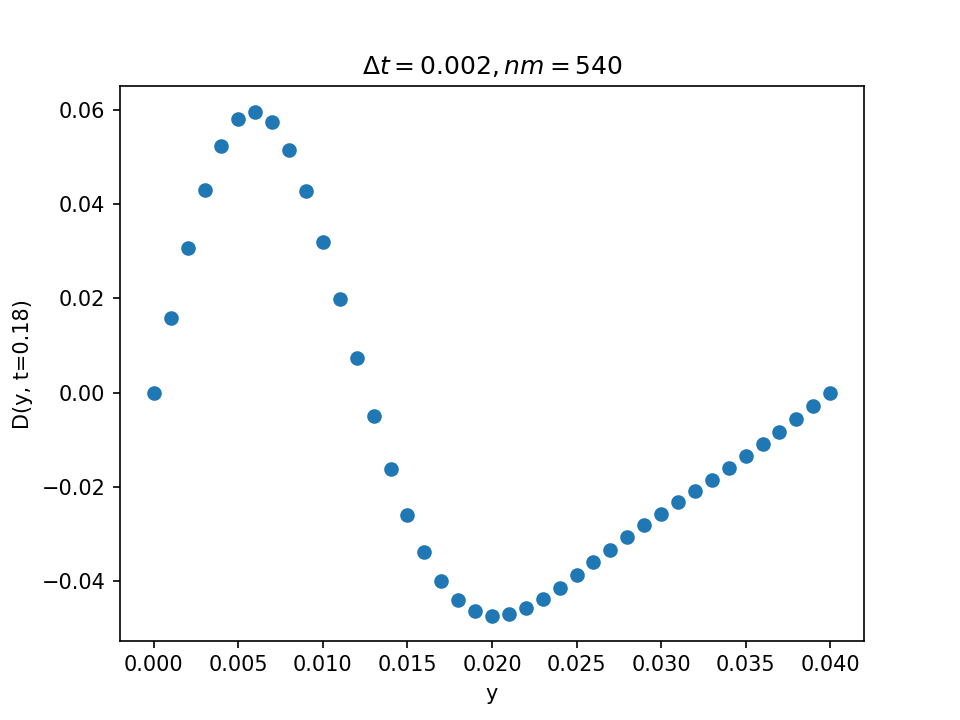

<IPython.core.display.Javascript object>


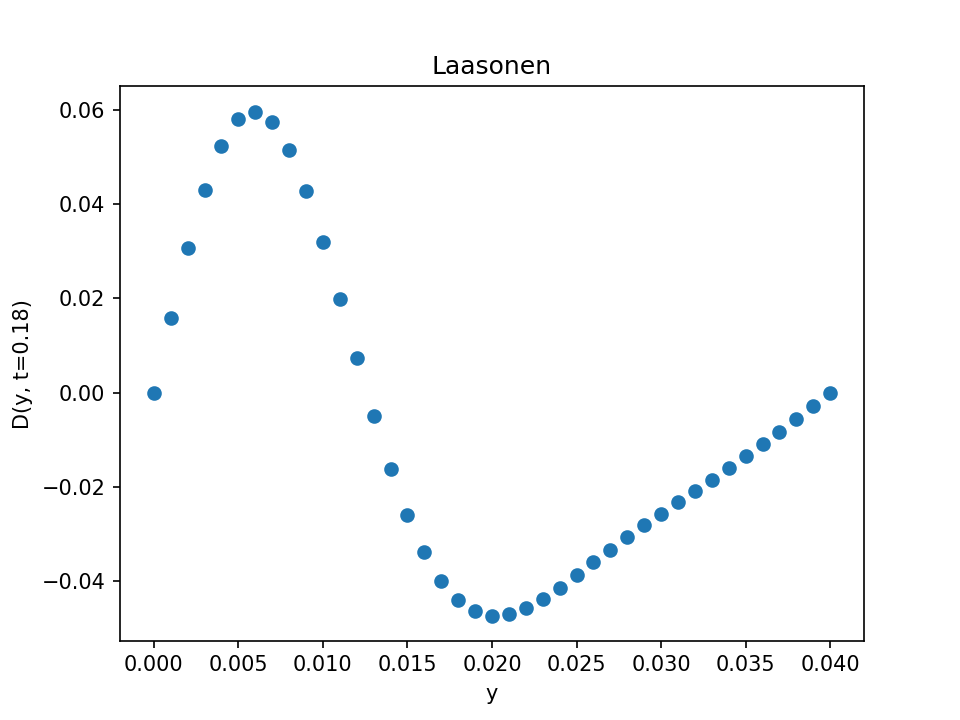

<IPython.core.display.Javascript object>


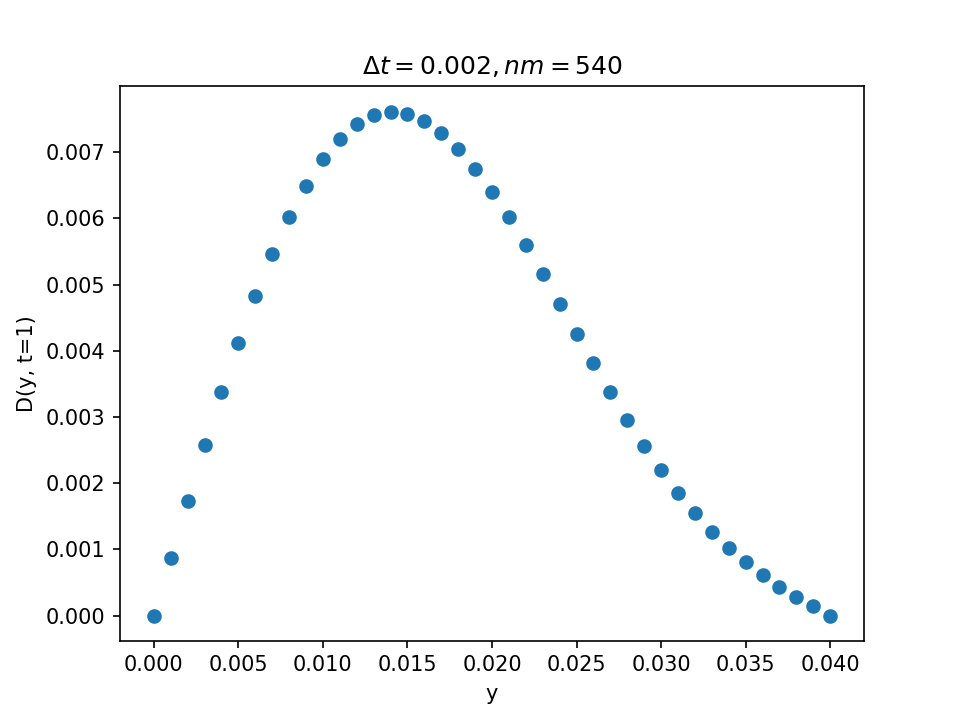

<IPython.core.display.Javascript object>


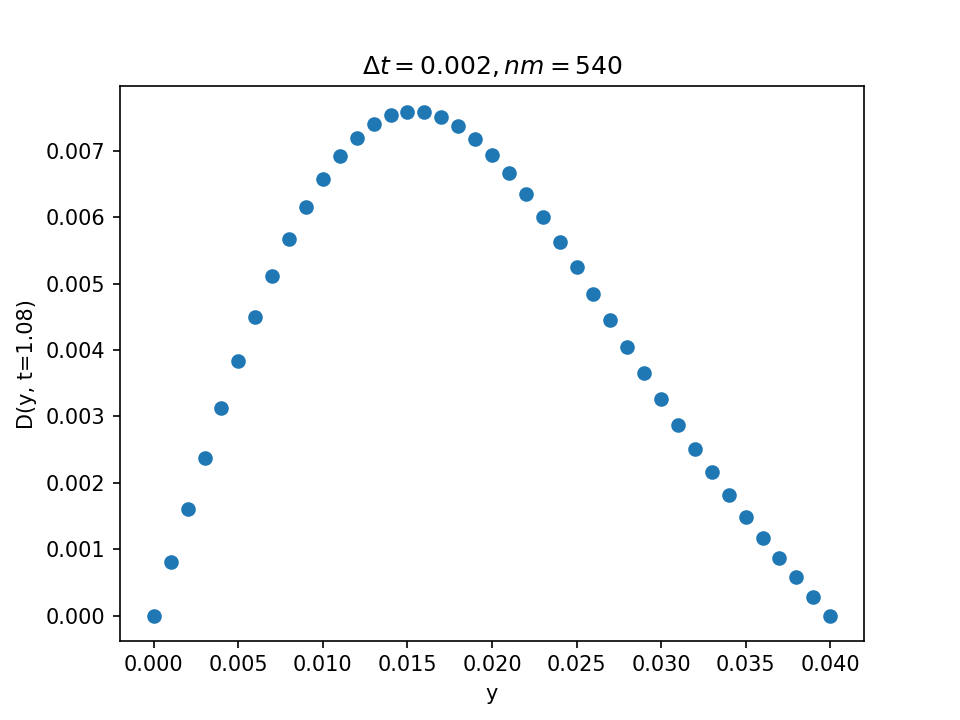

<IPython.core.display.Javascript object>


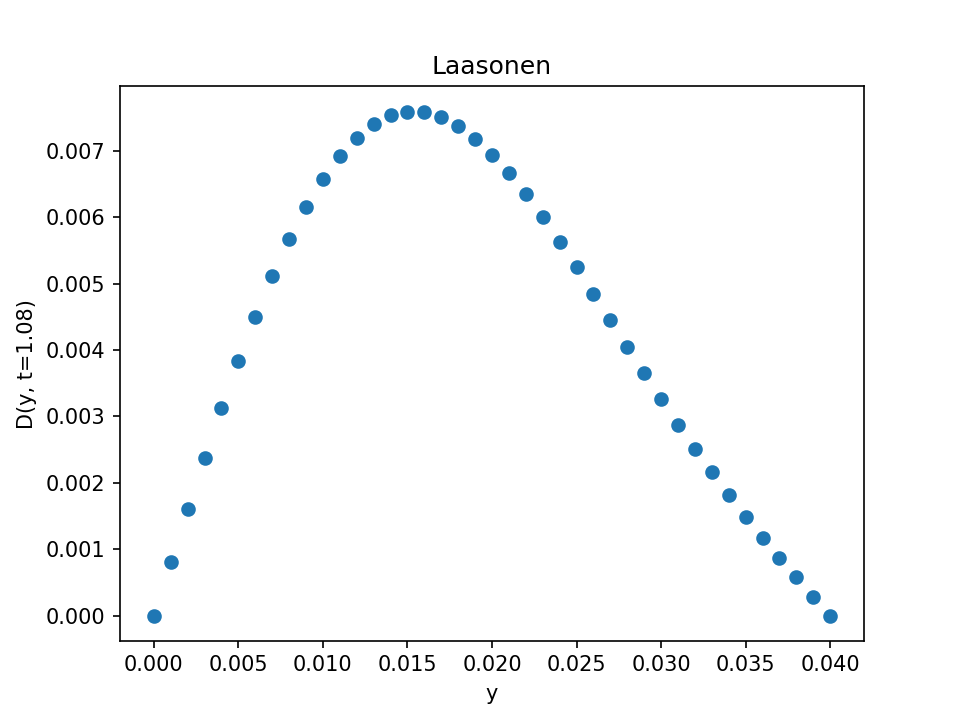

In [150]:
# Error plot: t=0.18, t=1.08 - compare to other methods
# time indices
t0ind = int(0.18/dt)
t1ind = -1

# error data
t0err = L1err[:,t0ind]
t1err = L1err[:,t1ind]

print(f't=0.18 abs DE: {np.sum(np.abs(t0err))}')
print(f't=1.08 abs DE: {np.sum(np.abs(t1err))}')

# THIS PART WILL BE USED LATER
tind = int(1/dt)
t1L1err = L1err[:,tind]
abs_t1L1err = np.sum(np.abs(t1L1err))
print(f't=1 abs DE: {abs_t1L1err}')
# END PART TO BE USED LATER


y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t0err)
plt.title('$\Delta t = 0.002, nm = 540$')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('L T1 t=0.18.png')

plt.figure()
plt.scatter(y, t0err)
plt.title('Laasonen')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('L t=0.18.png')

plt.figure()
plt.scatter(y, t1L1err)
plt.title('$\Delta t = 0.002, nm = 540$')
plt.ylabel('D(y, t=1)')
plt.xlabel('y')
plt.show()
plt.savefig('L T1 t=1.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.002, nm = 540$')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('L T1 t=1.08.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('Laasonen')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('L t=1.08.png')

### Trial 2: dt = 0.005, nm = 216

In [52]:
dt = 0.005
nm = 216

In [53]:
# Calculate solution
LuSOL2 = L(dt=dt, nm=nm, dy=dy, jm=jm)
LuSOL2[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [38.51059572, 38.5139885 , 38.51735506, 38.52069567],
       [37.02434284, 37.03110398, 37.03781294, 37.04447024],
       [35.54437003, 35.55445093, 35.56445418, 35.57438059],
       [34.07376068, 34.08708903, 34.10031502, 34.11343969],
       [32.61553084, 32.63201133, 32.64836571, 32.66459525],
       [31.17260781, 31.19212301, 31.21148955, 31.23070892],
       [29.74780954, 29.77022105, 29.79246275, 29.8145363 ],
       [28.34382512, 28.36897487, 28.39393521, 28.41870798],
       [26.96319649, 26.99090817, 27.01841258, 27.04571169],
       [25.60830147, 25.6383822 , 25.66823964, 25.69787588],
       [24.28133839, 24.31358041, 24.34558508, 24.37735457],
       [22.98431225, 23.01849476, 23.0524279 , 23.08611391],
       [21.71902265, 21.75491373, 21.79054551, 21.82592026],
       [20.48705348, 20.52441203, 20.56150347, 20.59833007],
       [19.28976446, 19.32834218, 19.3666471 , 19.40468144],
       [18.12828448, 18.

In [54]:
# Calculating error matrix
L2err = err_matrix(LuSOL2, dt=dt, nm=nm, dy=dy, jm=jm)
L2err[:,-4:]

array([[0.        , 0.        , 0.        , 0.        ],
       [0.0025019 , 0.00248856, 0.00247541, 0.00246245],
       [0.0049773 , 0.00495095, 0.00492497, 0.00489937],
       [0.00740015, 0.00736142, 0.00732325, 0.00728562],
       [0.00974526, 0.00969511, 0.00964567, 0.00959691],
       [0.01198873, 0.01192837, 0.01186886, 0.01181015],
       [0.01410832, 0.01403923, 0.01397107, 0.01390383],
       [0.0160838 , 0.01600765, 0.0159325 , 0.01585834],
       [0.01789725, 0.01781589, 0.01773556, 0.01765625],
       [0.01953333, 0.01944872, 0.01936514, 0.01928257],
       [0.02097945, 0.02089362, 0.02080879, 0.02072493],
       [0.02222591, 0.02214093, 0.02205687, 0.02197369],
       [0.02326599, 0.0231839 , 0.02310259, 0.02302207],
       [0.02409598, 0.02401871, 0.02394209, 0.02386609],
       [0.02471508, 0.02464447, 0.02457431, 0.0245046 ],
       [0.02512535, 0.02506304, 0.02500098, 0.02493916],
       [0.02533151, 0.02527895, 0.0252264 , 0.02517385],
       [0.02534076, 0.02529913,

<IPython.core.display.Javascript object>


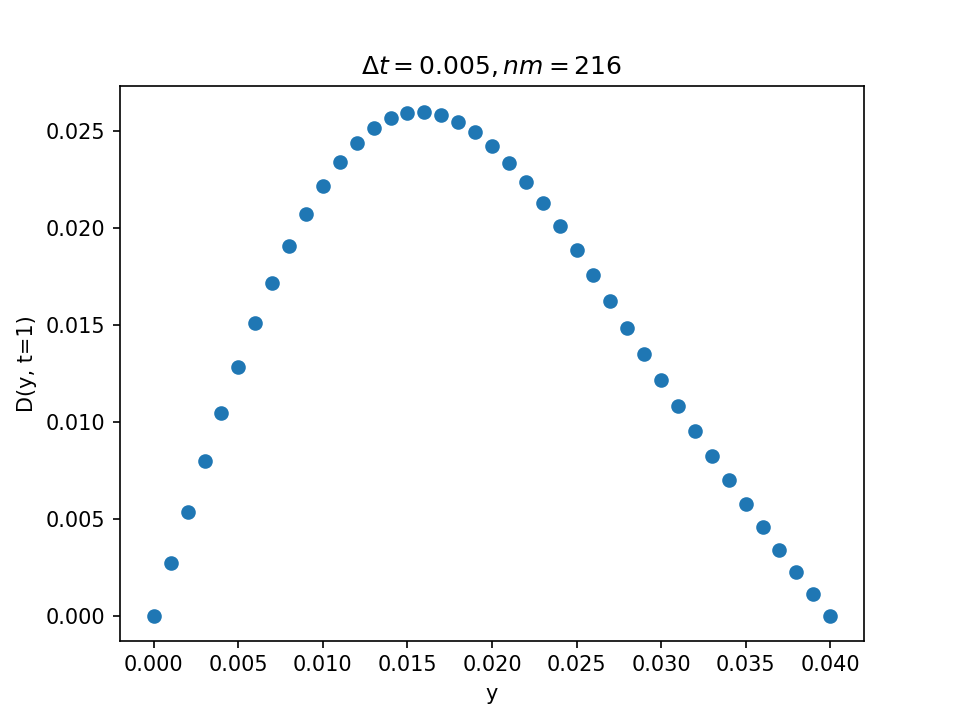

In [55]:
# Error plot: t=1 - compare to trials 3, 4, and 5
# time indices
t1ind = int(1/dt)

# error data
t1err = L2err[:,t1ind]
t1L2err = t1err # save this variable for later use

y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.005, nm = 216$')
plt.ylabel('D(y, t=1)')
plt.xlabel('y')
plt.show()
plt.savefig('L T2 t=1.png')

### Trial 3: dt = 0.01, nm = 108

In [56]:
dt = 0.01 # s
nm = 108 # s, steps in time (nm + 1 time points)

In [57]:
# Calcluate and print solution
LuSOL3 = L(dt=dt, nm=nm, dy=dy, jm=jm)
LuSOL3[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [38.49738982, 38.50434236, 38.51118697, 38.51792588],
       [36.99803438, 37.01188866, 37.02552813, 37.03895726],
       [35.50516453, 35.52581942, 35.54615476, 35.56617718],
       [34.02196346, 34.04926856, 34.07615252, 34.10262402],
       [32.55154359, 32.58530069, 32.61853921, 32.6512697 ],
       [31.096924  , 31.1368891 , 31.17624317, 31.21499856],
       [29.66100895, 29.7068946 , 29.75208266, 29.79658704],
       [28.24656744, 28.29804556, 28.34874615, 28.39868445],
       [26.85621414, 26.91291917, 26.96877395, 27.0237949 ],
       [25.49239179, 25.55392411, 25.61454129, 25.67426063],
       [24.1573553 , 24.22328497, 24.28824281, 24.3522468 ],
       [22.85315753, 22.92302817, 22.99187881, 23.05972789],
       [21.58163698, 21.65496981, 21.72724323, 21.79847585],
       [20.34440738, 20.42070538, 20.49591336, 20.57004989],
       [19.14284925, 19.22160133, 19.29924155, 19.37578823],
       [17.97810343, 18.

In [58]:
# Calculating error matrix
L3err = err_matrix(LuSOL3, dt=dt, nm=nm, dy=dy, jm=jm)
L3err[:,-4:]

array([[0.        , 0.        , 0.        , 0.        ],
       [0.00541059, 0.00534952, 0.00529009, 0.00523224],
       [0.01076514, 0.01064435, 0.0105268 , 0.01041235],
       [0.01600852, 0.01583069, 0.01565759, 0.01548903],
       [0.0210874 , 0.02085647, 0.02063162, 0.02041258],
       [0.02595113, 0.0256722 , 0.0254005 , 0.02513571],
       [0.03055251, 0.03023172, 0.02991906, 0.0296142 ],
       [0.03484853, 0.03449289, 0.03414604, 0.03380761],
       [0.03880099, 0.03841822, 0.03804461, 0.03767978],
       [0.042377  , 0.04197536, 0.04158294, 0.04119936],
       [0.04554944, 0.0451375 , 0.04473454, 0.04434018],
       [0.04829722, 0.04788366, 0.04747853, 0.04708147],
       [0.05060541, 0.05019884, 0.04979984, 0.04940809],
       [0.05246536, 0.05207407, 0.05168921, 0.05131051],
       [0.0538745 , 0.0535063 , 0.05314314, 0.05278478],
       [0.0548362 , 0.05449824, 0.05416368, 0.05383236],
       [0.05535944, 0.055058  , 0.05475815, 0.05445981],
       [0.05545833, 0.05519873,

<IPython.core.display.Javascript object>


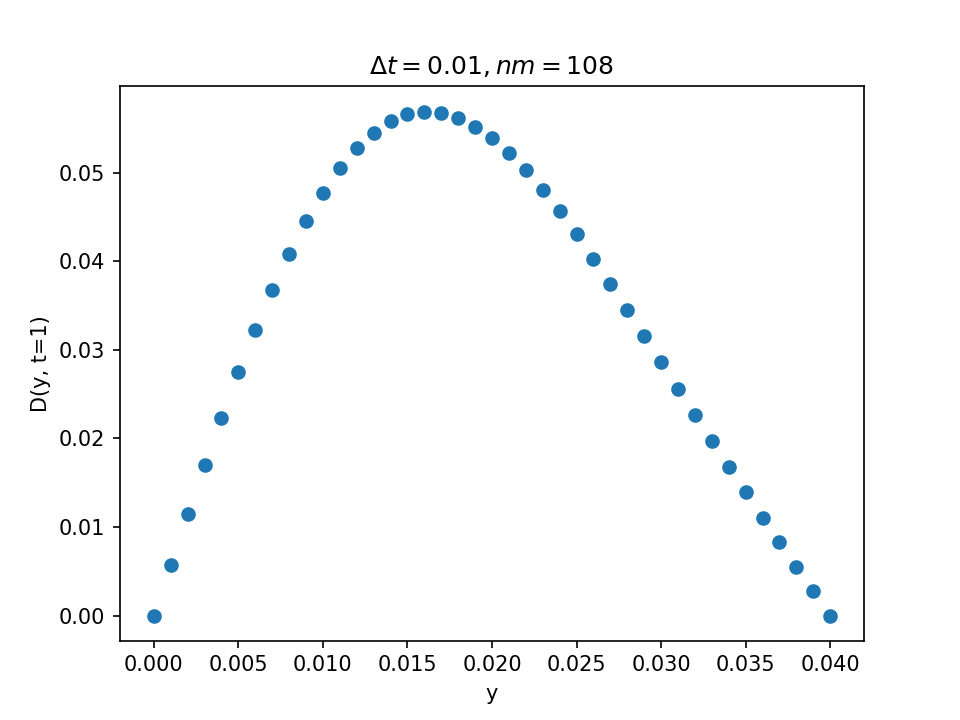

In [59]:
# Error plot: t=1 - compare to trial 2, 4, and 5
# time indices
t1ind = int(1/dt)

# error data
t1err = L3err[:,t1ind]
t1L3err = t1err # save this variable for later use

y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.01, nm = 108$')
plt.ylabel('D(y, t=1)')
plt.xlabel('y')
plt.show()
plt.savefig('L T3 t=1.png')

### Trial 4: dt = 0.1, nm = 11, T=1.1.

In [60]:
dt = 0.1
nm = 11
T = 1.1

In [61]:
# Calcluate and print solution
LuSOL4 = L(dt=dt, nm=nm, dy=dy, jm=jm)
LuSOL4[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [38.20079831, 38.31169193, 38.40337511, 38.48044426],
       [36.40791905, 36.62849417, 36.81097526, 36.96444009],
       [34.62760406, 34.95546116, 35.22698467, 35.45550803],
       [32.86593603, 33.29753677, 33.65550669, 33.95710701],
       [31.12876392, 31.65950181, 32.10052502, 32.47260461],
       [29.42163409, 30.04592482, 30.56586699, 31.00524874],
       [27.74972866, 28.46111699, 29.05516944, 29.55814088],
       [26.1178123 , 26.90909204, 27.57184757, 28.13421143],
       [24.53018838, 25.39353158, 26.11906743, 26.73619736],
       [22.99066483, 23.91775653, 24.69972213, 25.36662246],
       [21.50253005, 22.4847046 , 23.31641211, 24.02778029],
       [20.06853867, 21.09691417, 21.97142962, 22.72172007],
       [18.6909067 , 19.75651431, 20.66674738, 21.45023544],
       [17.37131547, 18.46522079, 19.40401137, 20.21485625],
       [16.11092337, 17.22433766, 18.18453759, 19.01684319],
       [14.91038467, 16.

In [62]:
# Calculating error matrix
L4err = err_matrix(LuSOL4, dt=dt, nm=nm, dy=dy, jm=jm)
L4err[:,-4:]

array([[0.        , 0.        , 0.        , 0.        ],
       [0.08686629, 0.07324078, 0.06329186, 0.05577204],
       [0.17231548, 0.14546217, 0.12582126, 0.11095383],
       [0.25496795, 0.21566799, 0.18684086, 0.16496534],
       [0.33351769, 0.28290777, 0.24563318, 0.21724685],
       [0.40676551, 0.3462977 , 0.30152445, 0.26726839],
       [0.47364834, 0.40503954, 0.35389726, 0.31453847],
       [0.53326356, 0.45843679, 0.40220161, 0.35861192],
       [0.58488751, 0.50590775, 0.44596423, 0.39909653],
       [0.62798798, 0.54699514, 0.48479572, 0.4356584 ],
       [0.6622303 , 0.58137206, 0.51839556, 0.46802599],
       [0.68747723, 0.60884434, 0.54655489, 0.49599262],
       [0.70378306, 0.62934928, 0.56915693, 0.51941759],
       [0.71138237, 0.64295095, 0.58617533, 0.5382258 ],
       [0.71067427, 0.64983256, 0.59767037, 0.55240603],
       [0.70220288, 0.65028603, 0.60378335, 0.56200783],
       [0.68663502, 0.64469938, 0.60472931, 0.5671374 ],
       [0.664736  , 0.63354239,

<IPython.core.display.Javascript object>


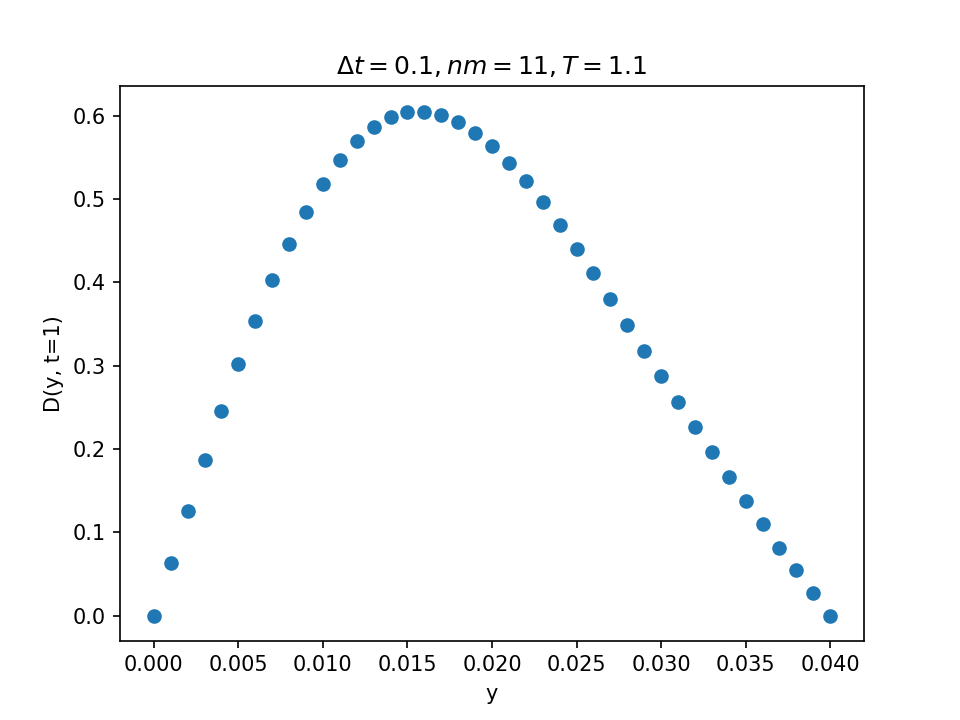

In [63]:
# Error plot: t=1 - compare to trial 2, 3, and 5
# time indices
t1ind = int(1/dt)

# error data
t1err = L4err[:,t1ind]
t1L4err = t1err # save this variable for later use

y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.1, nm = 11, T = 1.1$')
plt.ylabel('D(y, t=1)')
plt.xlabel('y')
plt.show()
plt.savefig('L T4 t=1.png')

### Trial 5: dt=0.2, nm=6, T=1.2

In [64]:
dt = 0.2
nm = 6
T = 1.2

In [65]:
# Calcluate and print solution
LuSOL5 = L(dt=dt, nm=nm, dy=dy, jm=jm)
LuSOL5[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [37.72455475, 38.10044902, 38.3329273 , 38.49229485],
       [35.46641966, 36.2095592 , 36.67121124, 36.98826177],
       [33.24192299, 34.33579241, 35.02013232, 35.491534  ],
       [31.06579512, 32.48722998, 33.38482161, 34.00566802],
       [28.95082253, 30.67141951, 31.77019272, 32.53410725],
       [26.90769683, 28.89525413, 30.1808812 , 31.08014821],
       [24.94500168, 27.164885  , 28.62119242, 29.6469096 ],
       [23.06929357, 25.48566526, 27.0950591 , 28.23730502],
       [21.2852435 , 23.86212228, 25.6060086 , 26.85401948],
       [19.59581484, 22.2979544 , 24.15713981, 25.49948995],
       [18.00245928, 20.79604779, 22.75110939, 24.17589014],
       [16.5053178 , 19.35850958, 21.39012647, 22.88511939],
       [15.10341769, 17.98671311, 20.075955  , 21.62879547],
       [13.79485938, 16.68135203, 18.80992275, 20.40825129],
       [12.57698928, 15.44249999, 17.59293591, 19.22453496],
       [11.44655641, 14.

In [66]:
# Calculating error matrix
L5err = err_matrix(LuSOL5, dt=dt, nm=nm, dy=dy, jm=jm)
L5err[:,-4:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.2989047 ,  0.18721558,  0.13373968,  0.1036232 ],
       [ 0.58807091,  0.37067533,  0.26558528,  0.20612526],
       [ 0.85865499,  0.5467796 ,  0.39369321,  0.30640666],
       [ 1.10323866,  0.71222374,  0.51631826,  0.40341038],
       [ 1.31609294,  0.86410992,  0.63185674,  0.49614146],
       [ 1.49325169,  1.00002831,  0.73888305,  0.58368447],
       [ 1.63245353,  1.11810721,  0.83617863,  0.66521858],
       [ 1.7329973 ,  1.21703456,  0.9227527 ,  0.7400298 ],
       [ 1.79554502,  1.29605408,  0.99785456,  0.8075201 ],
       [ 1.82189795,  1.35494073,  1.06097789,  0.86721341],
       [ 1.81476449,  1.39395949,  1.1118576 ,  0.91875844],
       [ 1.77753307,  1.41381215,  1.15046007,  0.96192845],
       [ 1.71405945,  1.41557596,  1.1769677 ,  0.99661817],
       [ 1.62847424,  1.40063771,  1.19175898,  1.02283826],
       [ 1.52501416,  1.37062626,  1.19538503,  1.0407074 ],
       [ 1.40787868,  1.

<IPython.core.display.Javascript object>


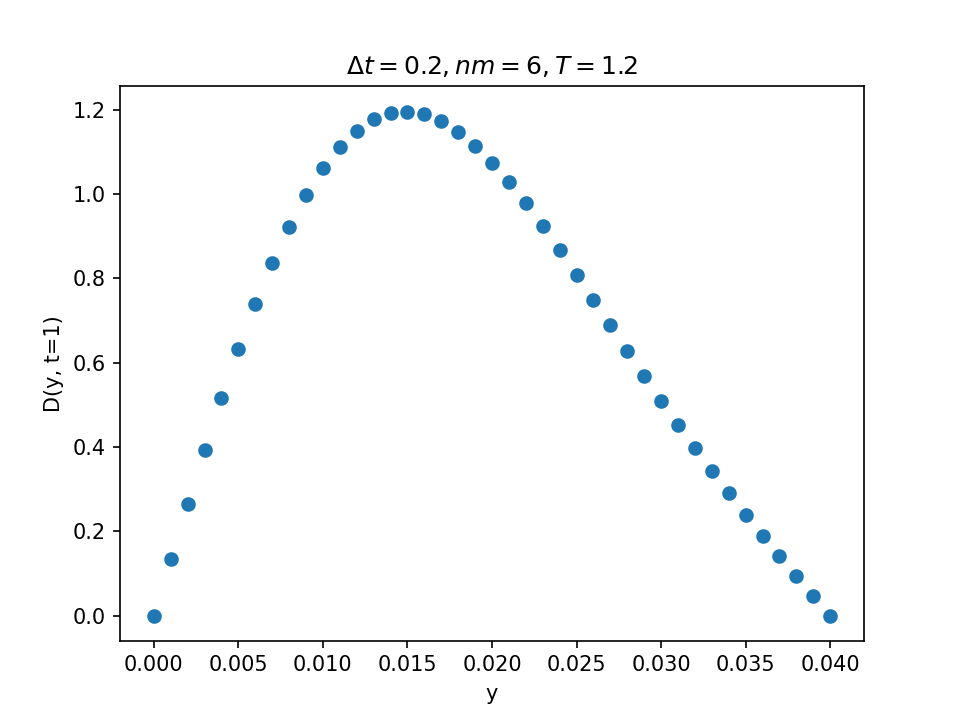

In [67]:
# Error plot: t=1 - compare to trial 2, 3, and 4
# time indices
t1ind = int(1/dt)

# error data
t1err = L5err[:,t1ind]
t1L5err = t1err # save this variable for later use

y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.2, nm = 6, T = 1.2$')
plt.ylabel('D(y, t=1)')
plt.xlabel('y')
plt.show()
plt.savefig('L T5 t=1.png')

### Error vs dt Plot

In [68]:
# Errors at t=1 stored in t1L'i'err from 1 to 5. Now get absolute error 
abs_t1L2err = np.sum(np.abs(t1L2err)) # dt = 0.005
abs_t1L3err = np.sum(np.abs(t1L3err)) # dt = 0.01
abs_t1L4err = np.sum(np.abs(t1L4err)) # dt = 0.1
abs_t1L5err = np.sum(np.abs(t1L5err)) # dt = 0.2
print(f't=1 abs DE: {abs_t1L2err}')
print(f't=1 abs DE: {abs_t1L3err}')
print(f't=1 abs DE: {abs_t1L4err}')
print(f't=1 abs DE: {abs_t1L5err}')

dts = np.array([0.002, 0.005, 0.01, 0.1, 0.2])
abs_t1errs = np.array([abs_t1L1err, abs_t1L2err, abs_t1L3err, abs_t1L4err, abs_t1L5err])

t=1 abs DE: 0.6179328207462192
t=1 abs DE: 1.3730027051466405
t=1 abs DE: 14.44118564414498
t=1 abs DE: 27.962416586014953


<IPython.core.display.Javascript object>


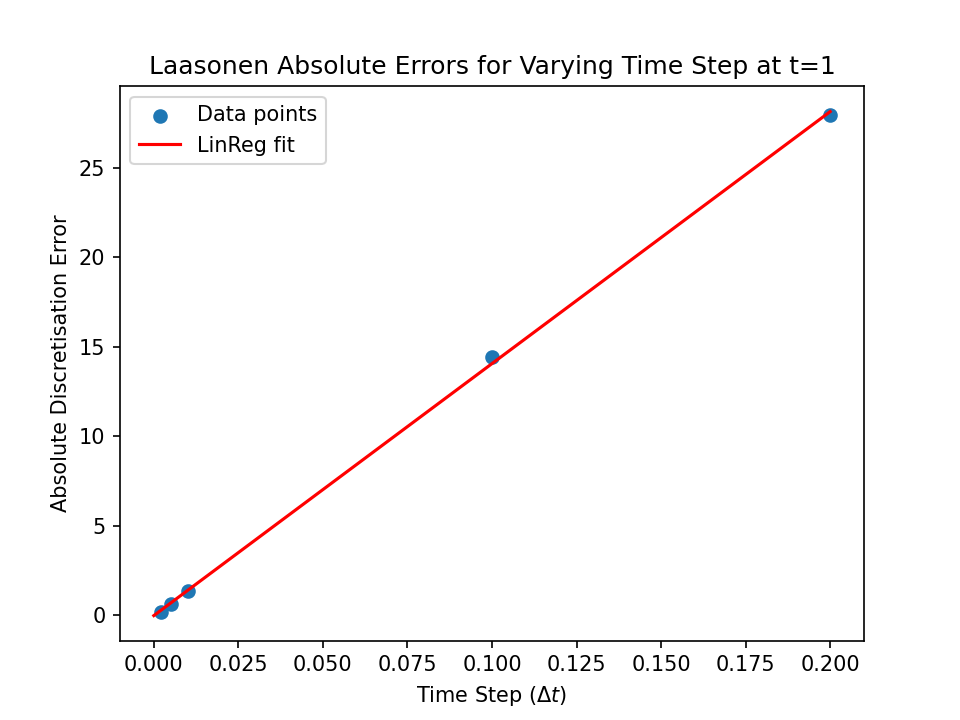

In [69]:
# Fit linear regression to data
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(dts.reshape(-1,1), abs_t1errs)

x_new = np.linspace(0, 0.2, 100)
y_new = model.predict(x_new.reshape(-1,1))



# Plot
plt.figure()
plt.scatter(dts, abs_t1errs, label='Data points')
# plt.plot(dts, abs_t1errs)
plt.plot(x_new, y_new, color='r', label='LinReg fit')
plt.legend()
plt.title('Laasonen Absolute Errors for Varying Time Step at t=1')
plt.ylabel('Absolute Discretisation Error')
plt.xlabel('Time Step ($\Delta t$)')
plt.show()
plt.savefig('Laasonen Errors.png')

## 5. Crank-Nicolsen Mixed

The Crank-Nicolsen method is the average of the FTCS and Laasonen methods, resulting in the scheme

$\frac{u_{j}^{n+1} - u_j^{n}}{\Delta t} = \frac{\nu}{2(\Delta y)^2} [(u_{j+1}^{n} - 2u_j^{n} + u_{j-1}^{n}) + (u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1})]$

Rearranging for the tridiagonal system,

$u_{j}^{n+1} - u_j^{n} = \frac{\nu \Delta t}{2(\Delta y)^2} [(u_{j+1}^{n} - 2u_j^{n} + u_{j-1}^{n}) + (u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1})] = \gamma [(u_{j+1}^{n} - 2u_j^{n} + u_{j-1}^{n}) + (u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1})] \;\;\;\;\;\;\;\;\;\; \text{where } \gamma = \frac{\nu \Delta t}{2(\Delta y)^2}$

$\Rightarrow -\gamma u_{j-1}^{n+1} + (1 + 2\gamma)u_{j}^{n+1} - \gamma u_{j+1}^{n+1} = \gamma u_{j-1}^{n} + (1 - 2\gamma)u_{j}^{n} + \gamma u_{j+1}^{n}$

Again, this forms a tridiagonal system of linear equations $Au=b$.

#### Note
This is solved similarly to the Laasonen method, with the exception of the differing evaluation of the constants of the matrix b. For $j=1$ and $j=jm-1$ where the boundaries are involved, the b values are

For $j=1$:
- $(1 + 2\gamma)u_{1}^{n+1} - \gamma u_{2}^{n+1} = \gamma u_{0}^{n} + (1 - 2\gamma)u_{1}^{n} + \gamma u_{2}^{n} + \gamma u_{0}^{n+1} = 2\gamma U_0 + (1 - 2\gamma)u_{1}^{n} + \gamma u_{2}^{n}$

For $j=jm-1$:
- $-\gamma u_{jm-2}^{n+1} + (1 + 2\gamma)u_{jm-1}^{n+1} = \gamma u_{jm-2}^{n} + (1 - 2\gamma)u_{jm-1}^{n} + \gamma u_{jm}^{n} + \gamma u_{jm}^{n+1} = \gamma u_{jm-2}^{n} + (1 - 2\gamma)u_{jm-1}^{n}$


### Coding the algorithm (Matrix Inversion)

In [129]:
def CN(dt, nm, dy, jm):
    # Define empty solution matrix with initial and boundary conditions
    uSOL = np.zeros((jm+1,nm+1))
    uSOL[:,0] = np.linspace(0, jm*dy, jm+1)
    uSOL[0,:] = U0
    
    gamma = v*dt/(2 * dy**2)
    
    for n in range(1, nm +1):
        # // Build tridiagonal matrix system //
        # uppder and lower diagonal
        ud = np.array([-gamma]*(jm-1)) # excluding j=0 and jm, i.e. only j=1, ..., jm-1
        ld = ud 
        
        # diagonal
        d = np.array([1 + 2*gamma]*(jm-1)) # same here

        # Creating matrix A
        A = np.zeros((jm-1,jm-1))
        
        for i in range((jm-1)-1): # excluding last main diagonal element
            A[i][i] = d[i]
            A[i+1][i] = ld[i]
            A[i][i+1] = ud[i]
        
        A[-1,-1] = d[-1] # indices -1 and jm-2 are interchangeable here, this is the last diagonal element

        # Defining constant matrix b
        b = np.zeros(jm-1)
        
        # j = 1 boundary value case
        b[0] = gamma*U0 + (1 - 2*gamma)*uSOL[1,n-1] + gamma*uSOL[2,n-1] + gamma*U0
        
        # j = 2, ..., jm-1 
        b[1:] = gamma*uSOL[1:-2,n-1] + (1 - 2*gamma)*uSOL[2:-1,n-1] + gamma*uSOL[3:,n-1]
        
        # // Solve for u at next time
        uSOL[1:-1, n] = np.linalg.solve(A, b) # u_j= 0 and u_jm have BCs so solve for j = 1, ..., jm-1
    
    return uSOL

### Trial 1: dt = 0.002, nm = 540 & back to T = 1.08

In [155]:
dt = 0.002 # s
nm = 540 # s, steps in time (nm + 1 time points)
dy = 0.001
jm = 40
T = 1.08

In [156]:
# Calculate and print solution
CNuSOL1 = CN(dt=dt, nm=nm, dy=dy, jm=jm)
CNuSOL1[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [38.51946245, 38.5207976 , 38.52212864, 38.52345559],
       [37.04200604, 37.04466685, 37.04731948, 37.04996395],
       [35.57068998, 35.57465755, 35.57861294, 35.5825562 ],
       [34.10852985, 34.11377606, 34.11900621, 34.12422035],
       [32.65847631, 32.66496406, 32.67143203, 32.67788027],
       [31.22339436, 31.23107797, 31.23873823, 31.24637524],
       [29.80604353, 29.81486908, 29.82366796, 29.83244026],
       [28.40905887, 28.41896479, 28.42884093, 28.43868741],
       [27.03493328, 27.04585081, 27.05673574, 27.06758819],
       [25.68600092, 25.69785481, 25.70967355, 25.72145728],
       [24.36442224, 24.37713135, 24.38980307, 24.40243755],
       [23.07217038, 23.08564841, 23.09908712, 23.11248667],
       [21.81101925, 21.82517546, 21.83929075, 21.85336526],
       [20.58253333, 20.59727327, 20.61197102, 20.62662673],
       [19.38805909, 19.4032854 , 19.41846857, 19.43360876],
       [18.22871828, 18.

In [157]:
# Calculating error matrix
CN1err = err_matrix(CNuSOL1, dt=dt, nm=nm, dy=dy, jm=jm)
CN1err[:,-4:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00030059, -0.00029955, -0.00029851, -0.00029747],
       [-0.00060061, -0.00059852, -0.00059643, -0.00059434],
       [-0.00089943, -0.00089628, -0.00089314, -0.00089   ],
       [-0.00119639, -0.00119217, -0.00118796, -0.00118376],
       [-0.00149076, -0.00148545, -0.00148016, -0.00147487],
       [-0.00178167, -0.00177526, -0.00176887, -0.00176248],
       [-0.00206816, -0.00206063, -0.00205312, -0.00204562],
       [-0.00234913, -0.00234046, -0.00233181, -0.00232318],
       [-0.00262332, -0.0026135 , -0.0026037 , -0.00259393],
       [-0.00288932, -0.00287835, -0.0028674 , -0.00285647],
       [-0.00314561, -0.00313347, -0.00312136, -0.00310928],
       [-0.00339047, -0.00337718, -0.00336391, -0.00335069],
       [-0.0036221 , -0.00360766, -0.00359327, -0.00357891],
       [-0.00383857, -0.00382302, -0.00380752, -0.00379206],
       [-0.00403788, -0.00402126, -0.00400469, -0.00398816],
       [-0.00421796, -0.

-0.03133526155256883
-0.004716481946616113
t=0.18 abs DE = 0.6810527746033187
t=1.08 abs DE = 0.11812338726835159


<IPython.core.display.Javascript object>


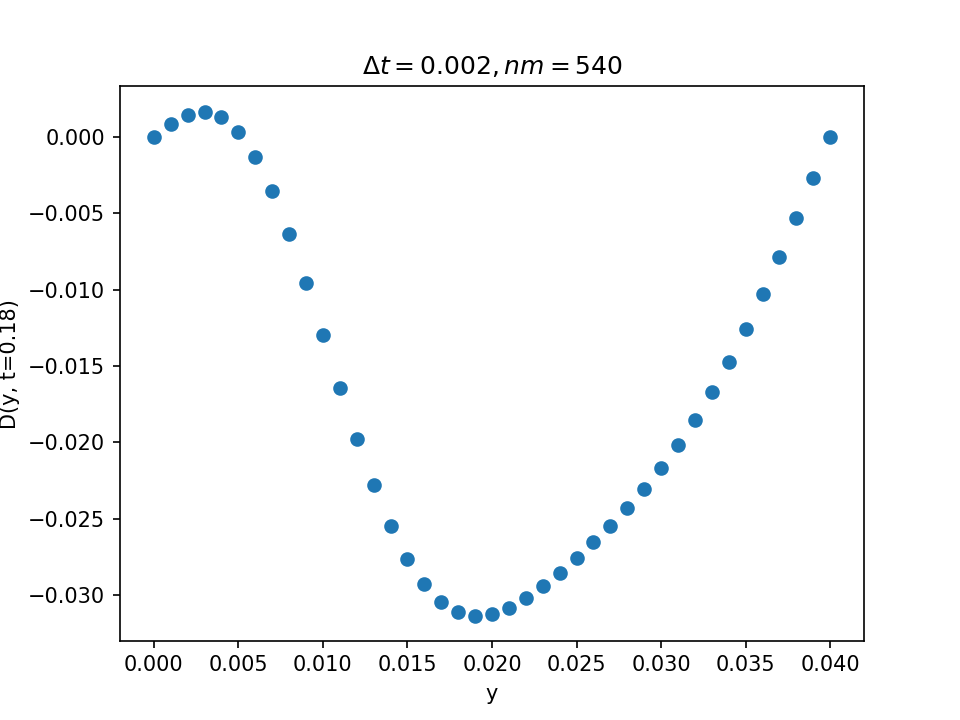

<IPython.core.display.Javascript object>


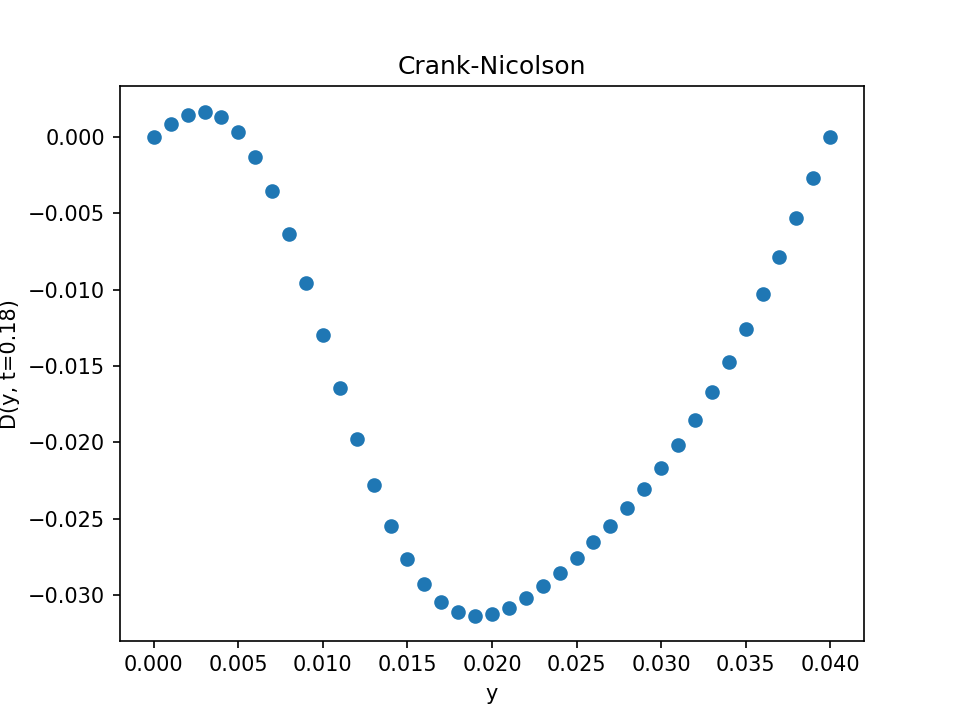

<IPython.core.display.Javascript object>


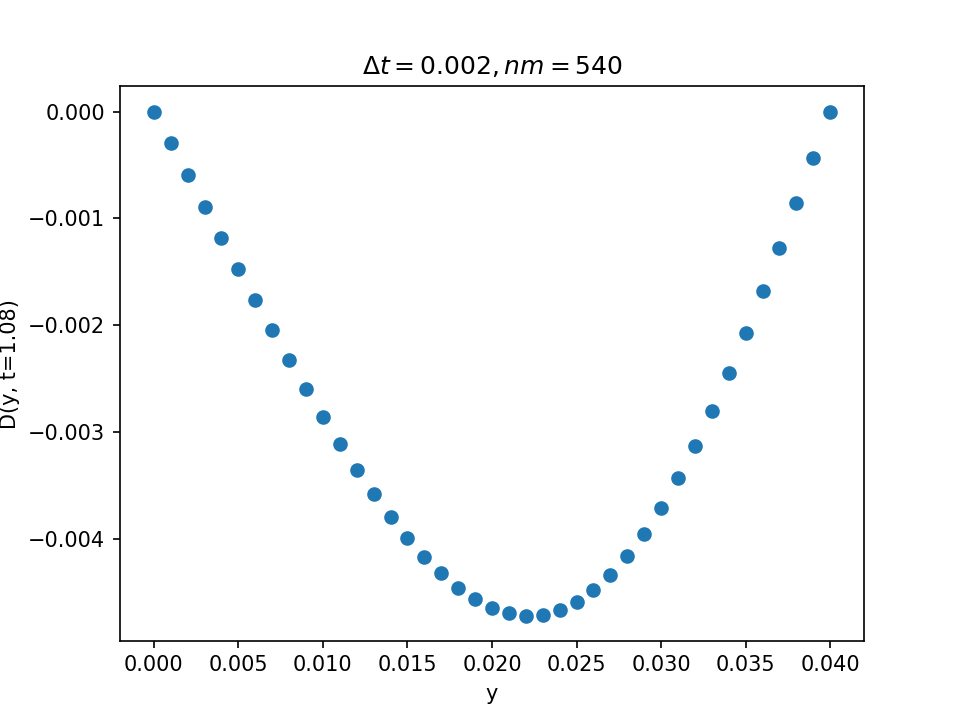

<IPython.core.display.Javascript object>


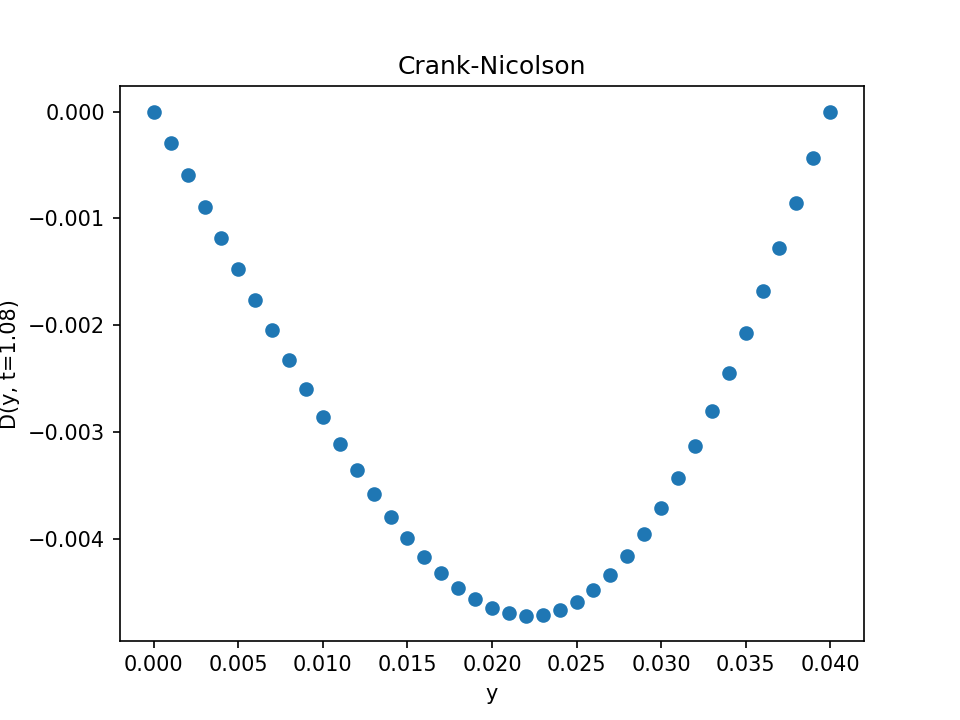

In [158]:
# Error plots: t=0.18, t=1.08 - Compare with other methods & trial 2 CN
# time indices
t0ind = int(0.18/dt)
t1ind = -1

# error data
t0err = CN1err[:,t0ind]
t1err = CN1err[:,t1ind]

print(np.min(t0err))
print(np.min(t1err))

# ABSOLUTE DISCRETIZATION ERROR CALCULATION
abs_t0CN1err = np.sum(np.abs(t0err))
print(f't=0.18 abs DE = {abs_t0CN1err}')
abs_t1CN1err = np.sum(np.abs(t1err))
print(f't=1.08 abs DE = {abs_t1CN1err}')
# END OF ADEC


y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t0err)
plt.title('$\Delta t = 0.002, nm = 540$')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('CN T1 t=0.18.png')

plt.figure()
plt.scatter(y, t0err)
plt.title('Crank-Nicolson')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('CN t=0.18.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.002, nm = 540$')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('CN T1 t=1.08.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('Crank-Nicolson')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('CN t=1.08.png')

<IPython.core.display.Javascript object>


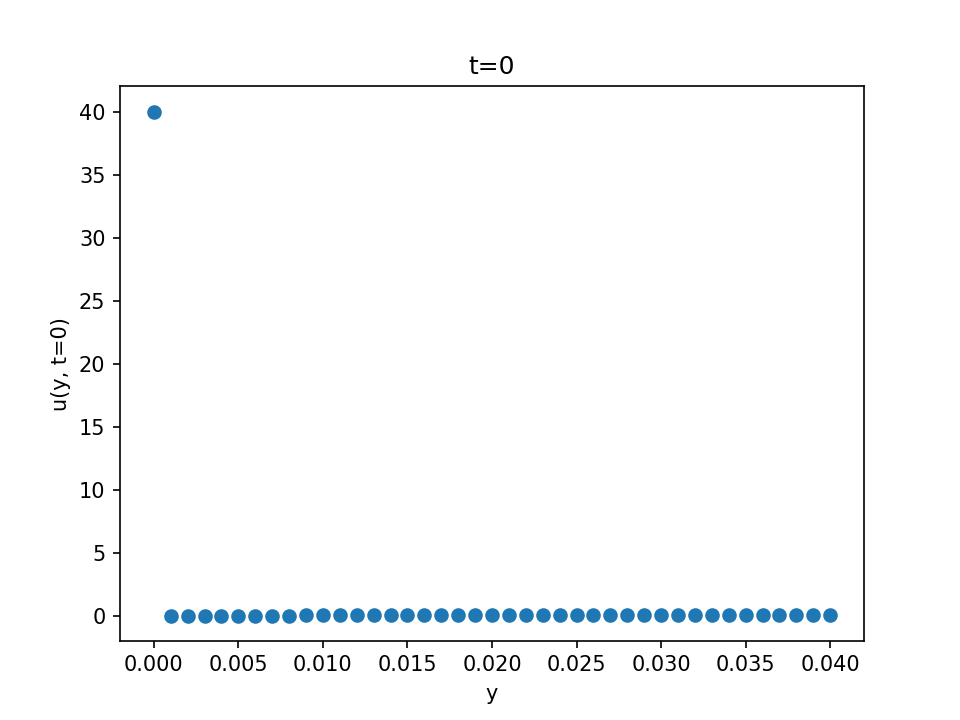

<IPython.core.display.Javascript object>


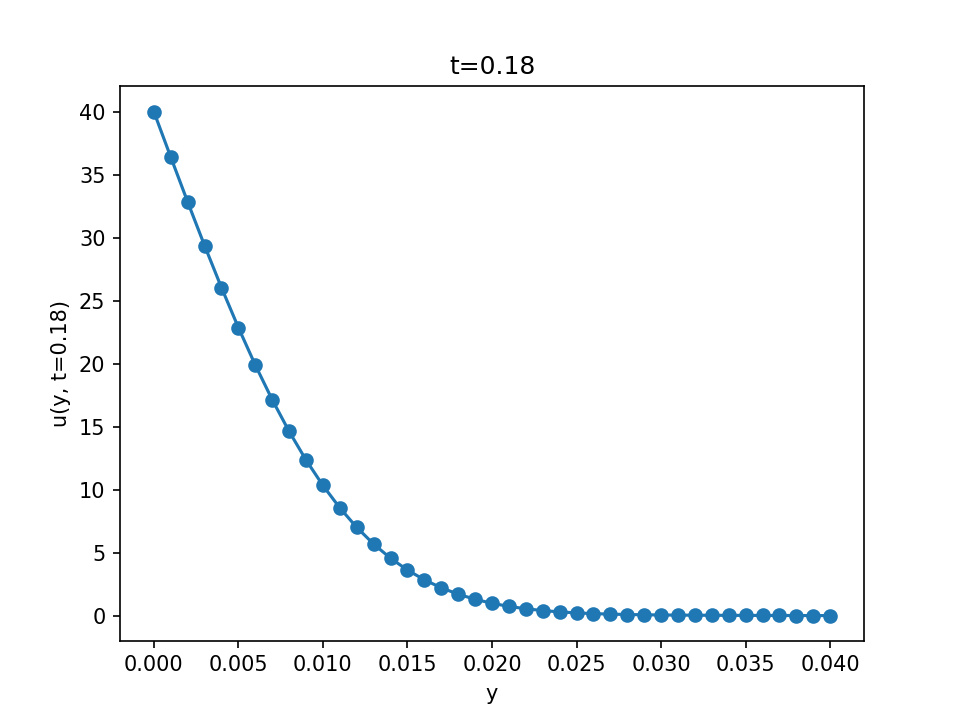

<IPython.core.display.Javascript object>


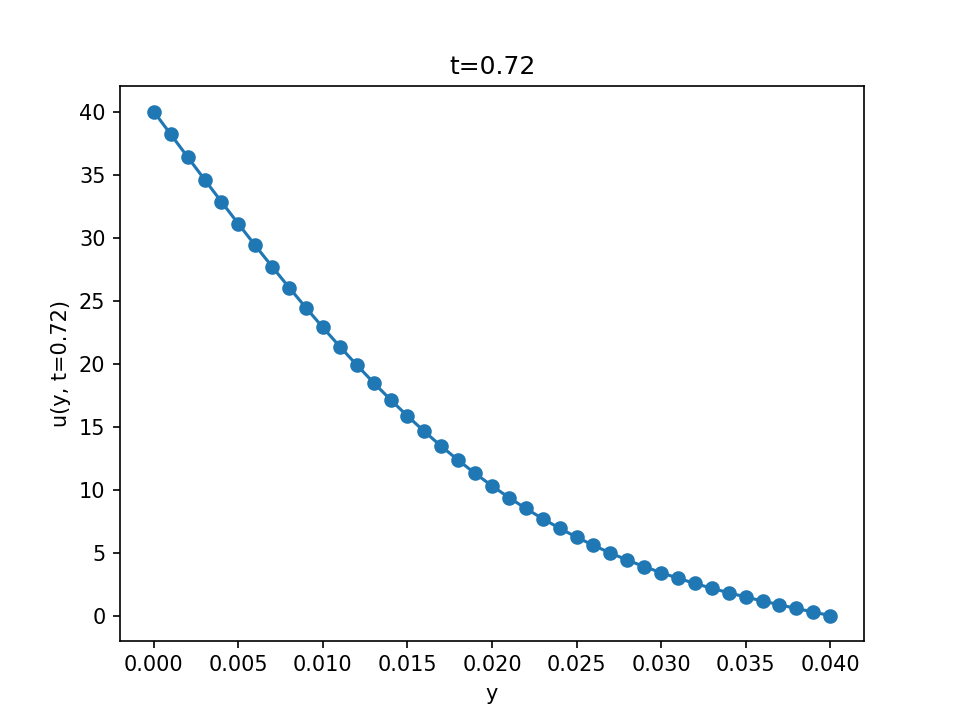

<IPython.core.display.Javascript object>


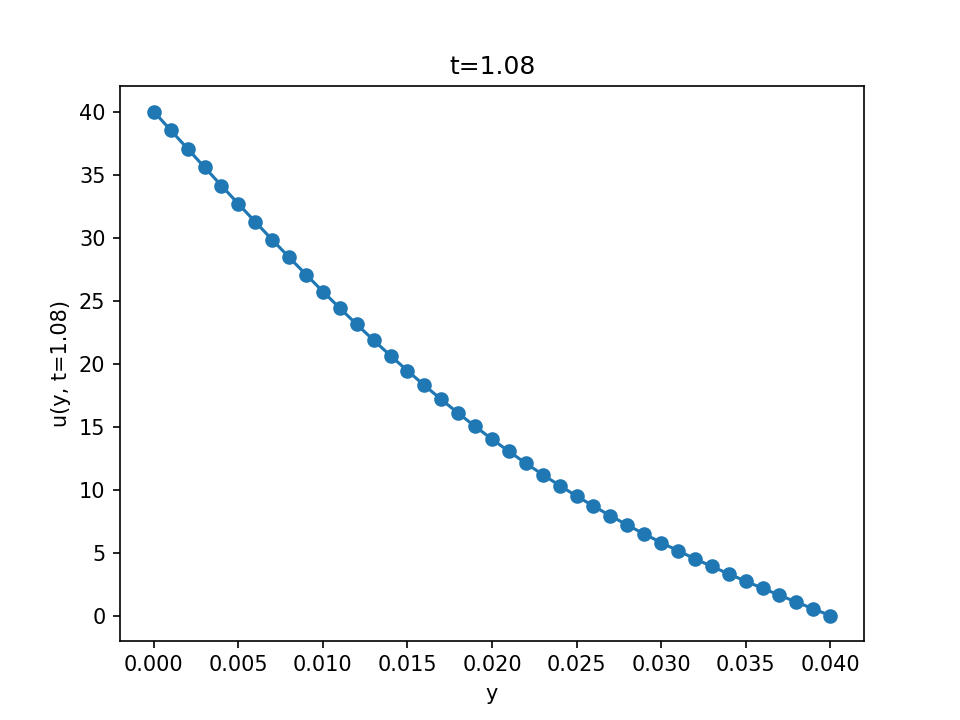

In [159]:
# Plots of system evolution at t=0, t=0.18, t=0.72, t=1.08s
# All exist in the grid.
t0ind = 0 # t=0
t1ind = int(0.18/dt) #t=0.36
t2ind = int(2*0.36/dt) #t=0.72
t3ind = -1

# Velocity data
t0u = CNuSOL1[:,t0ind]
t1u = CNuSOL1[:,t1ind]
t2u = CNuSOL1[:,t2ind]
t3u = CNuSOL1[:,t3ind]

y=np.linspace(0,jm*dy,jm+1)

#Plots
#t=0
plt.figure()
plt.scatter(y, t0u)
plt.title('t=0')
plt.ylabel('u(y, t=0)')
plt.xlabel('y')
plt.show()
plt.savefig('System t=0.png')

#t=0.18
plt.figure()
plt.scatter(y, t1u)
plt.plot(y, t1u)
plt.title('t=0.18')
plt.ylabel('u(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('System t=0.18.png')

#t=0.72
plt.figure()
plt.scatter(y, t2u)
plt.plot(y, t2u)
plt.title('t=0.72')
plt.ylabel('u(y, t=0.72)')
plt.xlabel('y')
plt.show()
plt.savefig('System t=0.72.png')

#t=1.08
plt.figure()
plt.scatter(y, t3u)
plt.plot(y, t3u)
plt.title('t=1.08')
plt.ylabel('u(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('System t=1.08.png')

### Trial 2: dt = 0.01, nm = 108

In [151]:
dt = 0.01 # s
nm = 108 # s, steps in time (nm + 1 time points)

In [152]:
# Calculate and print solution
CNuSOL2 = CN(dt=dt, nm=nm, dy=dy, jm=jm)
CNuSOL2[:,-4:]

array([[40.        , 40.        , 40.        , 40.        ],
       [38.50313537, 38.51002109, 38.51680056, 38.52347597],
       [37.00946861, 37.02319059, 37.03670108, 37.05000443],
       [35.52217459, 35.54263434, 35.56277941, 35.58261623],
       [34.04438227, 34.07143329, 34.09806943, 34.12429912],
       [32.57915244, 32.61260156, 32.64553957, 32.67797673],
       [31.12945592, 31.16906521, 31.20807194, 31.2464881 ],
       [29.69815277, 29.74364175, 29.78844233, 29.83256806],
       [28.28797249, 28.33902075, 28.38930112, 28.43882848],
       [26.90149542, 26.95774562, 27.01315539, 27.06774077],
       [25.54113562, 25.60219672, 25.66235236, 25.72161946],
       [24.20912519, 24.27457597, 24.33906415, 24.40260738],
       [22.90750026, 22.97689301, 23.04527427, 23.11266215],
       [21.63808873, 21.7109531 , 21.78276555, 21.85354442],
       [20.40249977, 20.47834672, 20.55310989, 20.62680761],
       [19.20211518, 19.280441  , 19.35765971, 19.43378947],
       [18.03808264, 18.

In [153]:
# Calculating error matrix
CN2err = err_matrix(CNuSOL2, dt=dt, nm=nm, dy=dy, jm=jm)
CN2err[:,-4:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00033496, -0.00032921, -0.00032351, -0.00031785],
       [-0.00066909, -0.00065758, -0.00064615, -0.00063482],
       [-0.00100154, -0.00098423, -0.00096706, -0.00095002],
       [-0.00133141, -0.00130826, -0.00128529, -0.00126253],
       [-0.00165773, -0.00162867, -0.00159987, -0.00157133],
       [-0.00197941, -0.0019444 , -0.00190971, -0.00187534],
       [-0.00229529, -0.00225426, -0.00221363, -0.00217341],
       [-0.00260406, -0.00255697, -0.00251036, -0.00246426],
       [-0.00290428, -0.0028511 , -0.0027985 , -0.0027465 ],
       [-0.00319438, -0.00313511, -0.00307653, -0.00301865],
       [-0.00347267, -0.00340733, -0.00334281, -0.00327911],
       [-0.00373732, -0.003666  , -0.00359562, -0.00352617],
       [-0.0039864 , -0.00390922, -0.00383311, -0.00375807],
       [-0.0042179 , -0.00413504, -0.00405339, -0.00397293],
       [-0.00442973, -0.00434143, -0.00425449, -0.00416888],
       [-0.00461977, -0.

-0.02958825533042142
-0.004854819435864854
t=0.18 abs DE = 0.6986207326393872
t=1.08 abs DE = 0.12210665965293543


<IPython.core.display.Javascript object>


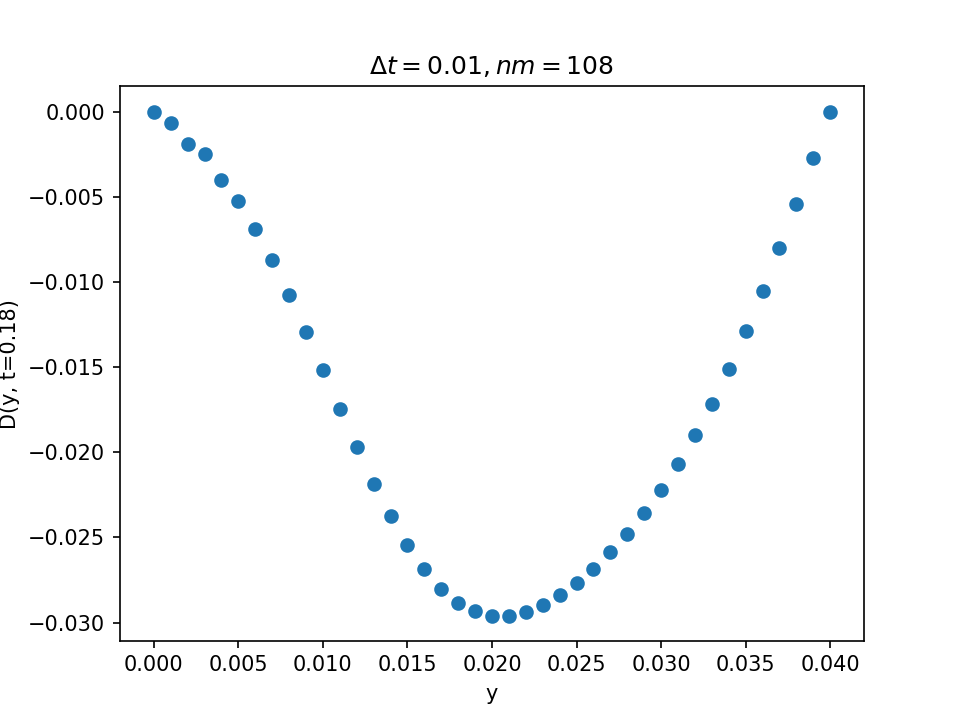

<IPython.core.display.Javascript object>


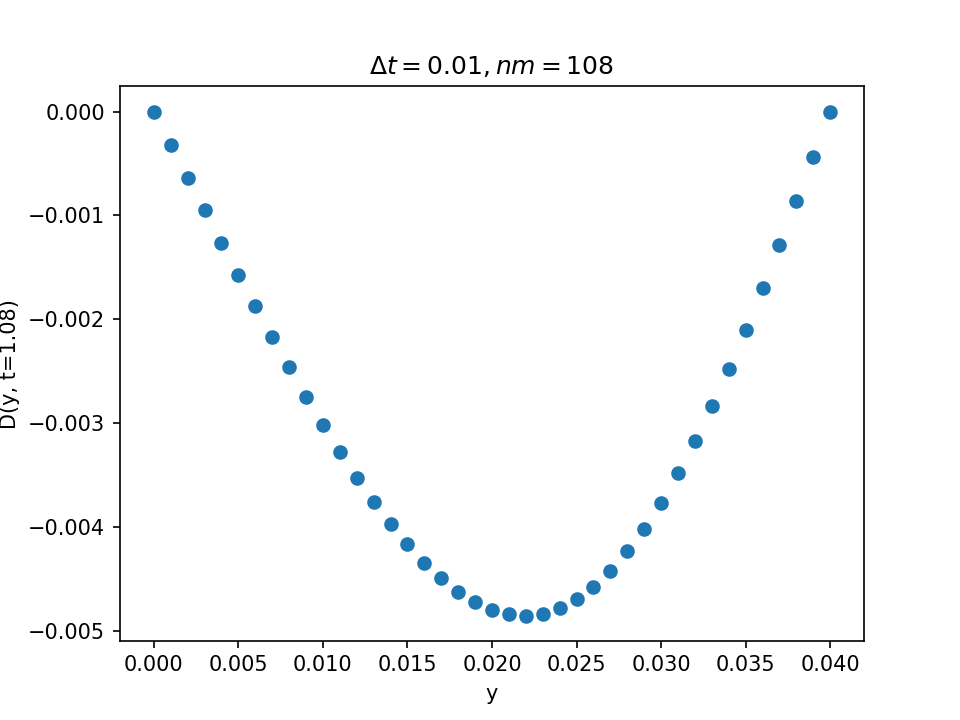

In [154]:
# Error plots: t=0.18, t=1.08 - compare with trial 1 CN
# time indices
t0ind = int(0.18/dt)
t1ind = -1

# error data
t0err = CN2err[:,t0ind]
t1err = CN2err[:,t1ind]

print(np.min(t0err))
print(np.min(t1err))

# ABSOLUTE DISCRETIZATION ERROR CALCULATION
abs_t0CN2err = np.sum(np.abs(t0err))
print(f't=0.18 abs DE = {abs_t0CN2err}')
abs_t1CN2err = np.sum(np.abs(t1err))
print(f't=1.08 abs DE = {abs_t1CN2err}')
# END OF ADEC


y = np.linspace(0, jm*dy, jm+1)

# plot
plt.figure()
plt.scatter(y, t0err)
plt.title('$\Delta t = 0.01, nm = 108$')
plt.ylabel('D(y, t=0.18)')
plt.xlabel('y')
plt.show()
plt.savefig('CN T2 t=0.18.png')

plt.figure()
plt.scatter(y, t1err)
plt.title('$\Delta t = 0.01, nm = 108$')
plt.ylabel('D(y, t=1.08)')
plt.xlabel('y')
plt.show()
plt.savefig('CN T2 t=1.08.png')